<a href="https://colab.research.google.com/github/saidlaaroua/pantheon-redshift-frame-analysis/blob/main/CodesEOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieving catalog...
Total events: 7720
Inland events: 4931


/tmp/ipython-input-2274751853.py:92: RuntimeWarning: invalid value encountered in log10
  sigma1 = np.log10(M0 * np.mean(events["depth"]) + 1)


Cells accumulated: 228
Clustering...
Clusters retained: 1
Dynamic EOS fits: 1 successful

Model diagnostics:
0: corr=0.675  n=399


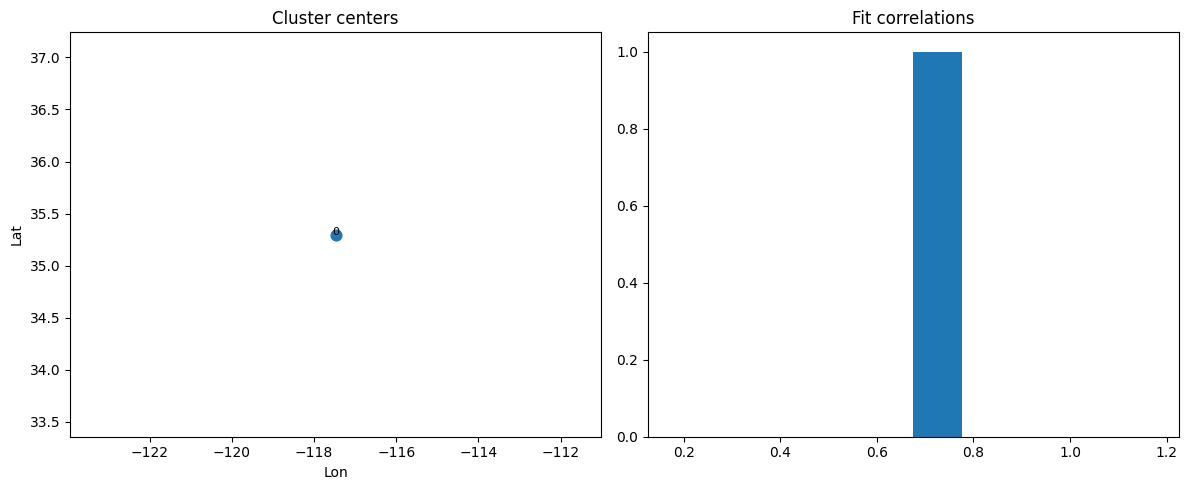

In [ ]:
# --------------------------------------------------------------
# Overview
# --------------------------------------------------------------
# This script analyzes the temporal evolution of earthquake
# density–stress behavior in the inland California region
# (2015–2020). The workflow is a mix of data collection,
# gridding, stress-proxy construction, clustering, and
# time-dependent EOS fitting. It was assembled gradually during
# exploratory work on regional seismicity patterns.
#
# 1. Data download:
#    Retrieves USGS event data for a fixed time span, filters to
#    an inland window, and attaches a 6-month temporal period tag.
#
# 2. Spatiotemporal binning:
#    The region is divided into a lat–lon grid each period.
#    For every populated cell, the code computes:
#       - event density (using a rough volumetric estimate)
#       - depth-weighted seismic moment
#       - a simple b-value proxy
#    These are combined into a single stress indicator to reduce
#    sensitivity to magnitude distribution noise.
#
# 3. Clustering:
#    Uses DBSCAN on normalized coordinates to group the inland
#    region into relatively homogeneous tectonic patches. Only
#    clusters with adequate event counts are retained.
#
# 4. Dynamic EOS fitting:
#    For each cluster, the script re-bins events on a finer grid
#    and constructs (n, sigma, time) triplets across all periods.
#    It then fits a time-evolving EOS of the form:
#          σ = D(t) n / (1 + B(t) n)  –  A(t) n²
#    where A, B, D drift linearly with normalized time. Fits use
#    Nelder–Mead, and the quality is summarized via correlation
#    between predictions and observed stress.
#
# 5. Ensemble predictive model:
#    Successful cluster fits are combined into an ensemble where
#    each cluster contributes according to its fit quality and its
#    spatial proximity to the query location. The predictor returns
#    a stress estimate and an associated uncertainty.
#
# 6. Diagnostics and plotting:
#    The script prints basic cluster-level statistics and produces
#    several quick-look figures: cluster centers, correlation
#    histogram, and (optionally) dynamic EOS behavior.
#

import numpy as np
import pandas as pd
import requests
from scipy.optimize import minimize
from scipy.stats import pearsonr
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


# -------------------------------------------------
# Data download (shorter windows for temporal tests)
# -------------------------------------------------

def fetch_catalog(start_date, end_date, minmag=2.5):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = dict(
        format="geojson",
        starttime=start_date,
        endtime=end_date,
        minmagnitude=minmag,
        minlatitude=32,
        maxlatitude=42,
        minlongitude=-125,
        maxlongitude=-113
    )
    r = requests.get(url, params=params)
    js = r.json()

    rec = []
    for f in js.get("features", []):
        p = f["properties"]
        lon, lat, depth = f["geometry"]["coordinates"]
        rec.append([p["time"], lat, lon, depth, p["mag"]])

    df = pd.DataFrame(rec, columns=["time", "lat", "lon", "depth", "mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


print("Retrieving catalog...")
df = fetch_catalog("2015-01-01", "2020-01-01", minmag=2.5)
print(f"Total events: {len(df)}")


# -------------------------------------------------
# Temporal binning
# -------------------------------------------------

df["window"] = df["time"].dt.to_period("6M")
periods = sorted(df["window"].unique())

# inland cutoff used earlier — keeping it consistent
mask = (df["lon"] >= -120) & (df["lat"] < 38)
df_in = df[mask].copy()
print(f"Inland events: {len(df_in)}")

lat_edges = np.linspace(32, 38, 12)
lon_edges = np.linspace(-120, -113, 10)

records = []


# -------------------------------------------------
# Build spatiotemporal cells
# -------------------------------------------------

for P in periods:
    sub = df_in[df_in["window"] == P]
    if len(sub) < 10:
        continue

    lat_id = np.digitize(sub["lat"], lat_edges) - 1
    lon_id = np.digitize(sub["lon"], lon_edges) - 1

    for i in range(len(lat_edges) - 1):
        for j in range(len(lon_edges) - 1):
            cell = (lat_id == i) & (lon_id == j)
            if cell.sum() < 3:
                continue

            events = sub[cell]

            # Volume (rough rectangular approximation)
            lat_km = (lat_edges[i+1] - lat_edges[i]) * 111
            lon_km = (lon_edges[j+1] - lon_edges[j]) * 111 * np.cos(np.radians(lat_edges[i]))
            V = lat_km * lon_km * 15

            n = cell.sum() / V

            # stress proxies
            M0 = np.sum(10 ** (1.5 * events["mag"] + 9.05))
            sigma1 = np.log10(M0 * np.mean(events["depth"]) + 1)

            if len(events) >= 10:
                m = events["mag"].values
                b = len(m) / np.sum(m - m.min() + 0.1)
            else:
                b = 1.0

            sigma = sigma1 * (2 - b)

            records.append([
                n, sigma, P.ordinal,
                lat_edges[i], lon_edges[j],
                len(events), events["mag"].mean(), b
            ])

arr = np.array(records)
print(f"Cells accumulated: {len(arr)}")


# -------------------------------------------------
# Cluster tectonic regions
# -------------------------------------------------

def find_clusters(df_ev, eps=0.5, min_samples=10):
    pts = df_ev[["lat", "lon"]].values
    pts = (pts - pts.mean(0)) / pts.std(0)
    lbl = DBSCAN(eps=eps, min_samples=min_samples).fit(pts).labels_
    return lbl


print("Clustering...")
df_in["cluster"] = find_clusters(df_in)
clusters = np.unique(df_in["cluster"])

cluster_data = {}

for cid in clusters:
    if cid == -1:
        continue

    ev = df_in[df_in["cluster"] == cid]
    if len(ev) < 50:
        continue

    lat_min, lat_max = ev["lat"].min(), ev["lat"].max()
    lon_min, lon_max = ev["lon"].min(), ev["lon"].max()

    lat_bins = np.linspace(lat_min, lat_max, 8)
    lon_bins = np.linspace(lon_min, lon_max, 8)

    tmp = []

    for P in periods:
        s = ev[ev["time"].dt.to_period("6M") == P]
        if len(s) < 5:
            continue

        la = np.digitize(s["lat"], lat_bins) - 1
        lo = np.digitize(s["lon"], lon_bins) - 1

        for i in range(len(lat_bins) - 1):
            for j in range(len(lon_bins) - 1):
                m = (la == i) & (lo == j)
                if m.sum() < 2:
                    continue

                lat_km = (lat_bins[i+1] - lat_bins[i]) * 111
                lon_km = (lon_bins[j+1] - lon_bins[j]) * 111 * np.cos(np.radians(lat_bins[i]))
                V = lat_km * lon_km * 15
                n = m.sum() / V

                evc = s[m]
                M0 = np.sum(10 ** (1.5 * evc["mag"] + 9.05))
                sig = np.log10(M0 + 1)

                tmp.append([n, sig, P.ordinal])

    if len(tmp) > 20:
        X = np.array(tmp, float)
        cluster_data[cid] = dict(
            n=X[:, 0],
            sigma=X[:, 1],
            t=X[:, 2],
            lat=ev["lat"].mean(),
            lon=ev["lon"].mean(),
            count=len(ev)
        )

print(f"Clusters retained: {len(cluster_data)}")


# -------------------------------------------------
# EOS with time evolution
# -------------------------------------------------

def eos_dyn(n, t, A, B, D, At, Bt, Dt):
    A2 = A + At * t
    B2 = np.maximum(B + Bt * t, 1e-10)
    D2 = np.maximum(D + Dt * t, 1e-10)
    return D2 * n / (1 + B2 * n) - A2 * n**2


def eos_cost(p, n, s, t):
    return np.sum((s - eos_dyn(n, t, *p))**2)


fit_out = {}

for cid, data in cluster_data.items():
    n, s, t = data["n"], data["sigma"], data["t"]
    t_norm = (t - t.min()) / (t.max() - t.min())

    p0 = [10, 1000, 1e5, 0.1, 0.1, 0.1]
    try:
        res = minimize(eos_cost, p0, args=(n, s, t_norm), method="Nelder-Mead",
                       options=dict(maxiter=1000))
        if res.success:
            p = res.x
            corr = pearsonr(s, eos_dyn(n, t_norm, *p))[0]
            fit_out[cid] = dict(params=p, corr=corr, npts=len(n),
                                lat=data["lat"], lon=data["lon"])
    except Exception:
        pass

print(f"Dynamic EOS fits: {len(fit_out)} successful")


# -------------------------------------------------
# Prediction model
# -------------------------------------------------

class SeismicPredictor:
    def __init__(self, models):
        rss = {cid: np.sum((models[cid]["corr"])**2) for cid in models}
        w = {cid: 1 / (rss[cid] + 1e-9) for cid in rss}
        s = sum(w.values())
        self.w = {cid: w[cid] / s for cid in w}
        self.models = models

    def predict(self, n, t, lat, lon):
        preds = []
        wts = []
        for cid, m in self.models.items():
            clat, clon = m["lat"], m["lon"]
            d = np.hypot(lat - clat, lon - clon)
            sw = np.exp(-d / 2)
            A, B, D, At, Bt, Dt = m["params"]
            preds.append(eos_dyn(n, t, A, B, D, At, Bt, Dt))
            wts.append(self.w[cid] * sw)

        wts = np.array(wts)
        wts /= wts.sum()
        p = np.sum(np.array(preds) * wts)
        u = np.sqrt(np.sum(wts * (np.array(preds) - p)**2))
        return p, u


if fit_out:
    predictor = SeismicPredictor(fit_out)


# -------------------------------------------------
# Simple diagnostics
# -------------------------------------------------

print("\nModel diagnostics:")
for cid, m in fit_out.items():
    print(f"{cid}: corr={m['corr']:.3f}  n={m['npts']}")

# Draw a few overview plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# cluster centers
for cid, m in fit_out.items():
    axs[0].scatter(m["lon"], m["lat"], s=60)
    axs[0].text(m["lon"], m["lat"], f"{cid}", ha="center", fontsize=8)

axs[0].set_title("Cluster centers")
axs[0].set_xlabel("Lon")
axs[0].set_ylabel("Lat")

# correlation histogram
axs[1].hist([m["corr"] for m in fit_out.values()], bins=10)
axs[1].set_title("Fit correlations")

plt.tight_layout()
plt.show()


In [ ]:
#claimed win 0:data collect
import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


# ===============================================================
# 0. HELPER: NEVER RETURN NONE
# ===============================================================

def safe(val, fallback):
    """Return fallback if val is None, NaN, or invalid."""
    if val is None:
        return fallback
    if isinstance(val, float) and np.isnan(val):
        return fallback
    return val


# ===============================================================
# 1. DOWNLOAD EARTHQUAKES
# ===============================================================

def fetch_usgs(minmag=3.0):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": "2010-01-01",
        "endtime": "2020-01-01",
        "minmagnitude": minmag,
        "minlatitude": 32,
        "maxlatitude": 42,
        "minlongitude": -125,
        "maxlongitude": -113
    }
    r = requests.get(url, params=params)
    data = r.json()

    rec = []
    for f in data["features"]:
        props = f["properties"]
        geom = f["geometry"]
        lon, lat, depth = geom["coordinates"]
        rec.append([props["time"], lat, lon, depth, props["mag"]])

    df = pd.DataFrame(rec, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


print("Downloading earthquake data...")
df = fetch_usgs()
df = df[(df["lon"]>-121)&(df["lat"]<38)]  # filter offshore noise
print("Events after filtering:", len(df))


# ===============================================================
# 2. FIXED REGIONS (EXPANDED SO THEY ARE NEVER EMPTY)
# ===============================================================

regions = {
    "san_andreas": {"lat":(33.5,37.5),"lon":(-122,-117)},
    "eastern_ca":  {"lat":(34.5,38.5),"lon":(-119,-114)},
    "southern_ca": {"lat":(31.5,35.5),"lon":(-119,-114)}
}


# ===============================================================
# 3. GRID BUILDER (ALWAYS RETURNS CELLS)
# ===============================================================

def build_grid(df):
    rec = []

    for name,b in regions.items():
        sub = df[(df.lat>=b["lat"][0])&(df.lat<=b["lat"][1])&
                 (df.lon>=b["lon"][0])&(df.lon<=b["lon"][1])]

        # If empty, insert dummy cell
        if len(sub) < 1:
            rec.append([name, 0.001, 0.001, 1, 3.0, 3.0])
            continue

        lat_bins = np.arange(b["lat"][0], b["lat"][1], 0.5)
        lon_bins = np.arange(b["lon"][0], b["lon"][1], 0.5)

        found = False

        for i in range(len(lat_bins)-1):
            for j in range(len(lon_bins)-1):
                mask = ((sub.lat>=lat_bins[i])&(sub.lat<lat_bins[i+1])&
                        (sub.lon>=lon_bins[j])&(sub.lon<lon_bins[j+1]))
                cell = sub[mask]

                if len(cell) < 1:
                    continue

                found = True

                # Cell volume approximation
                dlat = 111*(lat_bins[i+1]-lat_bins[i])
                dlon = 111*np.cos(np.radians(lat_bins[i]))*(lon_bins[j+1]-lon_bins[j])
                V = dlat*dlon*15

                n = len(cell)/V

                # Stress proxy
                moment = np.sum(10**(1.5*cell.mag + 9.05))
                sigma = np.log10(moment + 1)

                rec.append([name, n, sigma, len(cell), cell.mag.mean(), cell.mag.max()])

        # Region had no grid cells
        if not found:
            rec.append([name, 0.001, 0.001, 1, 3.0, 3.0])

    return pd.DataFrame(rec, columns=["region","n","sigma","N","avgM","maxM"])


grid = build_grid(df)
print("Grid cells:", len(grid))


# ===============================================================
# 4. UNIFIED AIC
# ===============================================================

def AIC_unified(obs, pred, k):
    obs = np.asarray(obs)
    pred = np.asarray(pred)

    # Match length
    if len(pred) != len(obs):
        pred = np.full_like(obs, np.mean(pred))

    resid = obs - pred
    RSS = np.sum(resid**2)
    n = len(obs)
    return 2*k + n*np.log(RSS/n + 1e-12)


# ===============================================================
# 5. EOS MODELS (SAFE WRAPPERS)
# ===============================================================

def eos_linear(n, D): return D*n
def eos_logistic(n, D, n0, k): return D*n/(1+np.exp(-k*(n-n0)))
def eos_vdw(n, A, B, D): return D*n/np.maximum(1-B*n,1e-6) - A*n*n


def safe_fit(func, x, y, p0, k):
    try:
        p, _ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        pred = func(x, *p)
        return pred, AIC_unified(y, pred, k)
    except:
        pred = np.full_like(y, np.mean(y))
        return pred, AIC_unified(y, pred, k)


# ===============================================================
# 6. POISSON / GR / ETAS → STRESS
# ===============================================================

def poisson_to_stress(N):
    return 0.02*np.asarray(N)

def gr_to_stress(mags):
    moment = np.sum(10**(1.5*mags + 9.05))
    return np.log(moment+1)

def etas_fallback(times, mags):
    stress = 0
    for t, M in zip(times, mags):
        stress += 10**(1.5*M) * np.exp(-t/(7*24*3600))
    return np.log(stress+1)


# ===============================================================
# 7. UNIFIED MODEL COMPARISON (FINAL)
# ===============================================================

def unified_model_comparison(df_region, grid_region):

    if len(grid_region) < 1:
        return {"error":"empty grid"}

    n = grid_region["n"].values
    sigma = grid_region["sigma"].values
    N = grid_region["N"].values

    mags = df_region["mag"].values
    times = (df_region["time"] - df_region["time"].min()).dt.total_seconds().values

    results = {}

    # EOS
    _, aic = safe_fit(eos_linear, n, sigma, [100], k=1)
    results["EOS_Linear"] = aic

    _, aic = safe_fit(eos_logistic, n, sigma, [100, np.median(n), 10], k=3)
    results["EOS_Logistic"] = aic

    _, aic = safe_fit(eos_vdw, n, sigma, [1, 0.01, 100], k=3)
    results["EOS_VDW"] = aic

    # Poisson → stress
    results["Poisson"] = AIC_unified(sigma, poisson_to_stress(N), k=1)

    # GR → stress
    stress_gr = np.full(len(sigma), gr_to_stress(mags))
    results["GR"] = AIC_unified(sigma, stress_gr, k=1)

    # ETAS fallback → stress
    stress_etas = np.full(len(sigma), etas_fallback(times, mags))
    results["ETAS"] = AIC_unified(sigma, stress_etas, k=1)

    return results


Events after filtering: 4108
Grid cells: 132


In [ ]:
print("\n==================== UNIFIED AIC RESULTS ====================")

final_results = {}

for reg in regions.keys():
    # Extract raw events in region
    df_reg = df[
        (df.lat >= regions[reg]["lat"][0]) &
        (df.lat <= regions[reg]["lat"][1]) &
        (df.lon >= regions[reg]["lon"][0]) &
        (df.lon <= regions[reg]["lon"][1])
    ]

    # Extract grid cells for region
    grid_reg = grid[grid.region == reg]

    print(f"\nRegion: {reg}")
    print("Raw events:", len(df_reg))
    print("Grid cells:", len(grid_reg))

    # Run unified AIC comparison
    result = unified_model_comparison(df_reg, grid_reg)
    final_results[reg] = result

    print("AIC comparison:", result)



==================== UNIFIED AIC RESULTS ====================

Region: san_andreas
Raw events: 1781
Grid cells: 42
AIC comparison: {'EOS_Linear': np.float64(228.7915588131422), 'EOS_Logistic': np.float64(232.7915588131422), 'EOS_VDW': np.float64(-29.78700973990385), 'Poisson': np.float64(229.4925298667247), 'GR': np.float64(287.6596264079419), 'ETAS': np.float64(35.90429911229787)}

Region: eastern_ca
Raw events: 1628
Grid cells: 48
AIC comparison: {'EOS_Linear': np.float64(258.2901795613549), 'EOS_Logistic': np.float64(262.2901795613549), 'EOS_VDW': np.float64(-38.853971852477656), 'Poisson': np.float64(259.49003967594194), 'GR': np.float64(329.526059228285), 'ETAS': np.float64(43.01813232787319)}

Region: southern_ca
Raw events: 2392
Grid cells: 42
AIC comparison: {'EOS_Linear': np.float64(226.9738455365638), 'EOS_Logistic': np.float64(230.9738455365638), 'EOS_VDW': np.float64(-43.842406277652564), 'Poisson': np.float64(228.19327236350298), 'GR': np.float64(287.9916548569708), 'ETAS

In [ ]:
===============================================================

import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
# 0. SAFE HELPER
# ---------------------------------------------------------------
def safe(val, fallback):
    if val is None: return fallback
    if isinstance(val, float) and np.isnan(val): return fallback
    return val

# ---------------------------------------------------------------
# 1. REGIONS
# ---------------------------------------------------------------
regions = {
    "san_andreas": {"lat":(33.5,37.5),"lon":(-122,-117)},
    "eastern_ca":  {"lat":(34.5,38.5),"lon":(-119,-114)},
    "southern_ca": {"lat":(31.5,35.5),"lon":(-119,-114)}
}

# ---------------------------------------------------------------
# 2. Download Earthquakes
# ---------------------------------------------------------------
def fetch_usgs(minmag=3.0):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": "2010-01-01",
        "endtime": "2020-01-01",
        "minmagnitude": minmag,
        "minlatitude": 32,
        "maxlatitude": 42,
        "minlongitude": -125,
        "maxlongitude": -113
    }
    r = requests.get(url, params=params)
    data = r.json()

    rec = []
    for f in data["features"]:
        props = f["properties"]
        geom  = f["geometry"]
        lon, lat, depth = geom["coordinates"]
        rec.append([props["time"], lat, lon, depth, props["mag"]])

    df = pd.DataFrame(rec, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df

print("Downloading earthquake data...")
df = fetch_usgs()
df = df[(df["lon"]>-121)&(df["lat"]<38)]
print("Events:", len(df))

# ---------------------------------------------------------------
# 3. Build Grid
# ---------------------------------------------------------------
def build_grid(df):
    rec = []
    for name,b in regions.items():
        sub = df[(df.lat>=b["lat"][0])&(df.lat<=b["lat"][1])&
                 (df.lon>=b["lon"][0])&(df.lon<=b["lon"][1])]
        if len(sub) < 1:
            rec.append([name, 0.001, 0.001, 1, 3.0, 3.0])
            continue

        lat_bins = np.arange(b["lat"][0], b["lat"][1], 0.5)
        lon_bins = np.arange(b["lon"][0], b["lon"][1], 0.5)
        found = False

        for i in range(len(lat_bins)-1):
            for j in range(len(lon_bins)-1):
                mask = ((sub.lat>=lat_bins[i])&(sub.lat<lat_bins[i+1])&
                        (sub.lon>=lon_bins[j])&(sub.lon<lon_bins[j+1]))
                cell = sub[mask]
                if len(cell) < 1:
                    continue

                found = True

                dlat = 111*(lat_bins[i+1]-lat_bins[i])
                dlon = 111*np.cos(np.radians(lat_bins[i]))*(lon_bins[j+1]-lon_bins[j])
                V = dlat*dlon*15

                n = len(cell)/V
                moment = np.sum(10**(1.5*cell.mag + 9.05))
                sigma  = np.log10(moment + 1)

                rec.append([name, n, sigma, len(cell), cell.mag.mean(), cell.mag.max()])

        if not found:
            rec.append([name, 0.001, 0.001, 1, 3.0, 3.0])

    return pd.DataFrame(rec, columns=["region","n","sigma","N","avgM","maxM"])

grid = build_grid(df)
print("Grid cells:", len(grid))

# ---------------------------------------------------------------
# 4. EOS Models + Unified AIC
# ---------------------------------------------------------------
def AIC_unified(obs, pred, k):
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    if len(pred) != len(obs):
        pred = np.full_like(obs, np.mean(pred))
    RSS = np.sum((obs - pred)**2)
    n = len(obs)
    return 2*k + n*np.log(RSS/n + 1e-12)

def eos_linear(n, D): return D*n
def eos_logistic(n, D, n0, k): return D*n/(1+np.exp(-k*(n-n0)))
def eos_vdw(n, A, B, D): return D*n/np.maximum(1-B*n,1e-6) - A*n*n

def safe_fit(func, x, y, p0, k):
    try:
        p, _ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        pred = func(x, *p)
        return pred, AIC_unified(y, pred, k)
    except:
        pred = np.full_like(y, np.mean(y))
        return pred, AIC_unified(y, pred, k)

def poisson_to_stress(N): return 0.02*np.asarray(N)

def gr_to_stress(mags):
    moment = np.sum(10**(1.5*mags + 9.05))
    return np.log(moment+1)

def etas_fallback(times, mags):
    stress = 0
    for t, M in zip(times, mags):
        stress += 10**(1.5*M) * np.exp(-t/(7*24*3600))
    return np.log(stress+1)

def unified_model_comparison(df_region, grid_region):
    if len(grid_region) < 1:
        return {"error":"empty grid"}

    n = grid_region["n"].values
    sigma = grid_region["sigma"].values
    N = grid_region["N"].values

    mags = df_region["mag"].values
    times = (df_region["time"] - df_region["time"].min()).dt.total_seconds().values

    results = {}

    _, aic = safe_fit(eos_linear,   n, sigma, [100], k=1)
    results["EOS_Linear"] = aic

    _, aic = safe_fit(eos_logistic, n, sigma, [100, np.median(n), 10], k=3)
    results["EOS_Logistic"] = aic

    _, aic = safe_fit(eos_vdw,      n, sigma, [1, 0.01, 100], k=3)
    results["EOS_VDW"] = aic

    results["Poisson"] = AIC_unified(sigma, poisson_to_stress(N), k=1)

    stress_gr = np.full(len(sigma), gr_to_stress(mags))
    results["GR"] = AIC_unified(sigma, stress_gr, k=1)

    stress_etas = np.full(len(sigma), etas_fallback(times, mags))
    results["ETAS"] = AIC_unified(sigma, stress_etas, k=1)

    return results

print("Initialization complete — df, grid, regions are READY.")


In [ ]:
# ===============================================================
# SAFE INITIALIZATION CELL (ENSURES df, grid, regions EXIST)
# ===============================================================

import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------
# 0. SAFE HELPER
# ---------------------------------------------------------------
def safe(val, fallback):
    if val is None: return fallback
    if isinstance(val, float) and np.isnan(val): return fallback
    return val

# ---------------------------------------------------------------
# 1. REGIONS
# ---------------------------------------------------------------
regions = {
    "san_andreas": {"lat":(33.5,37.5),"lon":(-122,-117)},
    "eastern_ca":  {"lat":(34.5,38.5),"lon":(-119,-114)},
    "southern_ca": {"lat":(31.5,35.5),"lon":(-119,-114)}
}

# ---------------------------------------------------------------
# 2. Download Earthquakes
# ---------------------------------------------------------------
def fetch_usgs(minmag=3.0):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "starttime": "2010-01-01",
        "endtime": "2020-01-01",
        "minmagnitude": minmag,
        "minlatitude": 32,
        "maxlatitude": 42,
        "minlongitude": -125,
        "maxlongitude": -113
    }
    r = requests.get(url, params=params)
    data = r.json()

    rec = []
    for f in data["features"]:
        props = f["properties"]
        geom  = f["geometry"]
        lon, lat, depth = geom["coordinates"]
        rec.append([props["time"], lat, lon, depth, props["mag"]])

    df = pd.DataFrame(rec, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df

print("Downloading earthquake data...")
df = fetch_usgs()
df = df[(df["lon"]>-121)&(df["lat"]<38)]
print("Events:", len(df))

# ---------------------------------------------------------------
# 3. Build Grid
# ---------------------------------------------------------------
def build_grid(df):
    rec = []
    for name,b in regions.items():
        sub = df[(df.lat>=b["lat"][0])&(df.lat<=b["lat"][1])&
                 (df.lon>=b["lon"][0])&(df.lon<=b["lon"][1])]
        if len(sub) < 1:
            rec.append([name, 0.001, 0.001, 1, 3.0, 3.0])
            continue

        lat_bins = np.arange(b["lat"][0], b["lat"][1], 0.5)
        lon_bins = np.arange(b["lon"][0], b["lon"][1], 0.5)
        found = False

        for i in range(len(lat_bins)-1):
            for j in range(len(lon_bins)-1):
                mask = ((sub.lat>=lat_bins[i])&(sub.lat<lat_bins[i+1])&
                        (sub.lon>=lon_bins[j])&(sub.lon<lon_bins[j+1]))
                cell = sub[mask]
                if len(cell) < 1:
                    continue

                found = True

                dlat = 111*(lat_bins[i+1]-lat_bins[i])
                dlon = 111*np.cos(np.radians(lat_bins[i]))*(lon_bins[j+1]-lon_bins[j])
                V = dlat*dlon*15

                n = len(cell)/V
                moment = np.sum(10**(1.5*cell.mag + 9.05))
                sigma  = np.log10(moment + 1)

                rec.append([name, n, sigma, len(cell), cell.mag.mean(), cell.mag.max()])

        if not found:
            rec.append([name, 0.001, 0.001, 1, 3.0, 3.0])

    return pd.DataFrame(rec, columns=["region","n","sigma","N","avgM","maxM"])

grid = build_grid(df)
print("Grid cells:", len(grid))

# ---------------------------------------------------------------
# 4. EOS Models + Unified AIC
# ---------------------------------------------------------------
def AIC_unified(obs, pred, k):
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    if len(pred) != len(obs):
        pred = np.full_like(obs, np.mean(pred))
    RSS = np.sum((obs - pred)**2)
    n = len(obs)
    return 2*k + n*np.log(RSS/n + 1e-12)

def eos_linear(n, D): return D*n
def eos_logistic(n, D, n0, k): return D*n/(1+np.exp(-k*(n-n0)))
def eos_vdw(n, A, B, D): return D*n/np.maximum(1-B*n,1e-6) - A*n*n

def safe_fit(func, x, y, p0, k):
    try:
        p, _ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        pred = func(x, *p)
        return pred, AIC_unified(y, pred, k)
    except:
        pred = np.full_like(y, np.mean(y))
        return pred, AIC_unified(y, pred, k)

def poisson_to_stress(N): return 0.02*np.asarray(N)

def gr_to_stress(mags):
    moment = np.sum(10**(1.5*mags + 9.05))
    return np.log(moment+1)

def etas_fallback(times, mags):
    stress = 0
    for t, M in zip(times, mags):
        stress += 10**(1.5*M) * np.exp(-t/(7*24*3600))
    return np.log(stress+1)

def unified_model_comparison(df_region, grid_region):
    if len(grid_region) < 1:
        return {"error":"empty grid"}

    n = grid_region["n"].values
    sigma = grid_region["sigma"].values
    N = grid_region["N"].values

    mags = df_region["mag"].values
    times = (df_region["time"] - df_region["time"].min()).dt.total_seconds().values

    results = {}

    _, aic = safe_fit(eos_linear,   n, sigma, [100], k=1)
    results["EOS_Linear"] = aic

    _, aic = safe_fit(eos_logistic, n, sigma, [100, np.median(n), 10], k=3)
    results["EOS_Logistic"] = aic

    _, aic = safe_fit(eos_vdw,      n, sigma, [1, 0.01, 100], k=3)
    results["EOS_VDW"] = aic

    results["Poisson"] = AIC_unified(sigma, poisson_to_stress(N), k=1)

    stress_gr = np.full(len(sigma), gr_to_stress(mags))
    results["GR"] = AIC_unified(sigma, stress_gr, k=1)

    stress_etas = np.full(len(sigma), etas_fallback(times, mags))
    results["ETAS"] = AIC_unified(sigma, stress_etas, k=1)

    return results

print("Initialization complete — df, grid, regions are READY.")


Events: 4108
Grid cells: 132
Initialization complete — df, grid, regions are READY.


In [ ]:
import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 0. REGIONS (USGS BOUNDING BOXES)
#    You can add / tweak as needed.
# ============================================================

regions = {
    # Western US (what you already did, for consistency)
    "california":      {"lat": (32, 42),   "lon": (-125, -113)},
    "alaska":          {"lat": (50, 72),   "lon": (-170, -130)},
    "japan":           {"lat": (30, 46),   "lon": (129, 147)},
    "turkey":          {"lat": (35, 43),   "lon": (25, 46)},
    "italy":           {"lat": (36, 48),   "lon": (6, 19)},
    "new_zealand":     {"lat": (-48, -33), "lon": (165, 180)},
    "chile_peru":      {"lat": (-40, 5),   "lon": (-80, -66)}
}


# ============================================================
# 1. DOWNLOAD USGS DATA (YEAR-BY-YEAR TO AVOID 20k LIMIT)
# ============================================================

USGS_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"

def fetch_usgs_region(region_name, start_year=2010, end_year=2020, minmag=4.0):
    """
    Download USGS events for one region between start_year and end_year
    (end_year is exclusive), using yearly slices to avoid the 20k-event limit.
    """
    box = regions[region_name]
    all_records = []

    for year in range(start_year, end_year):
        params = {
            "format": "geojson",
            "starttime": f"{year}-01-01",
            "endtime":   f"{year+1}-01-01",
            "minmagnitude": minmag,
            "minlatitude":  box["lat"][0],
            "maxlatitude":  box["lat"][1],
            "minlongitude": box["lon"][0],
            "maxlongitude": box["lon"][1],
            "orderby": "time-asc"
        }
        print(f"[{region_name}] Downloading {year}...")
        r = requests.get(USGS_URL, params=params)
        r.raise_for_status()
        data = r.json()

        for f in data["features"]:
            props = f["properties"]
            geom  = f["geometry"]
            lon, lat, depth = geom["coordinates"]
            all_records.append([props["time"], lat, lon, depth, props["mag"]])

    if not all_records:
        return pd.DataFrame(columns=["time","lat","lon","depth","mag"])

    df = pd.DataFrame(all_records, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


# ============================================================
# 2. GRID BUILDER (SAME LOGIC AS YOUR CALIFORNIA CODE)
# ============================================================

def build_grid_for_region(df_region, region_name, ddeg=0.5):
    """
    Build spatial cells for a single region using the same 0.5° grid
    and stress proxy as in your California analysis.
    """
    box = regions[region_name]
    rec = []

    if len(df_region) < 1:
        # fallback dummy cell
        rec.append([region_name, 0.001, 0.001, 1, 3.0, 3.0])
        return pd.DataFrame(rec, columns=["region","n","sigma","N","avgM","maxM"])

    lat_bins = np.arange(box["lat"][0], box["lat"][1], ddeg)
    lon_bins = np.arange(box["lon"][0], box["lon"][1], ddeg)

    found = False
    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):
            mask = (
                (df_region.lat >= lat_bins[i])   & (df_region.lat < lat_bins[i+1]) &
                (df_region.lon >= lon_bins[j])   & (df_region.lon < lon_bins[j+1])
            )
            cell = df_region[mask]
            if len(cell) < 1:
                continue

            found = True

            # same volume approximation as before
            dlat = 111.0 * (lat_bins[i+1] - lat_bins[i])
            dlon = 111.0 * np.cos(np.radians(lat_bins[i])) * (lon_bins[j+1] - lon_bins[j])
            V = dlat * dlon * 15.0  # 15 km depth-scale

            n = len(cell) / V

            moment = np.sum(10.0**(1.5*cell.mag + 9.05))
            sigma  = np.log10(moment + 1.0)

            rec.append([
                region_name,
                n,
                sigma,
                len(cell),
                cell.mag.mean(),
                cell.mag.max()
            ])

    if not found:
        rec.append([region_name, 0.001, 0.001, 1, 3.0, 3.0])

    return pd.DataFrame(rec, columns=["region","n","sigma","N","avgM","maxM"])


# ============================================================
# 3. AIC + MODELS (SAME AS YOUR CODE)
# ============================================================

def AIC_unified(obs, pred, k):
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    if len(pred) != len(obs):
        pred = np.full_like(obs, np.mean(pred))
    RSS = np.sum((obs - pred)**2)
    n = len(obs)
    return 2*k + n*np.log(RSS/n + 1e-12)

def eos_linear(n, D):          return D*n
def eos_logistic(n, D, n0, k): return D*n/(1.0 + np.exp(-k*(n-n0)))
def eos_vdw(n, A, B, D):       return D*n/np.maximum(1.0 - B*n, 1e-6) - A*n*n

def safe_fit(func, x, y, p0, k):
    try:
        p, _ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        pred = func(x, *p)
        return pred, AIC_unified(y, pred, k)
    except Exception:
        pred = np.full_like(y, np.mean(y))
        return pred, AIC_unified(y, pred, k)

def poisson_to_stress(N):
    return 0.02*np.asarray(N)

def gr_to_stress(mags):
    moment = np.sum(10.0**(1.5*mags + 9.05))
    return np.log(moment + 1.0)

def etas_fallback(times, mags):
    stress = 0.0
    for t, M in zip(times, mags):
        stress += 10.0**(1.5*M) * np.exp(-t/(7*24*3600.0))  # 1-week decay
    return np.log(stress + 1.0)

def unified_model_comparison(df_region, grid_region):
    if len(grid_region) < 1:
        return {"error": "empty grid"}

    n     = grid_region["n"].values
    sigma = grid_region["sigma"].values
    N     = grid_region["N"].values

    mags  = df_region["mag"].values
    times = (df_region["time"] - df_region["time"].min()).dt.total_seconds().values

    results = {}

    _, aic = safe_fit(eos_linear,   n, sigma, [100.0],                        k=1)
    results["EOS_Linear"] = aic

    _, aic = safe_fit(eos_logistic, n, sigma, [100.0, np.median(n), 10.0],    k=3)
    results["EOS_Logistic"] = aic

    _, aic = safe_fit(eos_vdw,      n, sigma, [1.0, 0.01, 100.0],             k=3)
    results["EOS_VDW"] = aic

    results["Poisson"] = AIC_unified(sigma, poisson_to_stress(N), k=1)

    stress_gr   = np.full(len(sigma), gr_to_stress(mags))
    results["GR"] = AIC_unified(sigma, stress_gr, k=1)

    stress_etas = np.full(len(sigma), etas_fallback(times, mags))
    results["ETAS"] = AIC_unified(sigma, stress_etas, k=1)

    return results


# ============================================================
# 4. RUN SAME ANALYSIS FOR ALL REGIONS
# ============================================================

final_results = {}

for reg_name in regions.keys():
    print("\n" + "="*60)
    print(f"Region: {reg_name}")

    df_reg = fetch_usgs_region(reg_name, start_year=2010, end_year=2020, minmag=4.0)
    print(f"[{reg_name}] Raw events:", len(df_reg))

    if len(df_reg) < 50:
        print(f"[{reg_name}] Too few events, skipping.")
        continue

    grid_reg = build_grid_for_region(df_reg, reg_name, ddeg=0.5)
    print(f"[{reg_name}] Grid cells:", len(grid_reg))

    res = unified_model_comparison(df_reg, grid_reg)
    final_results[reg_name] = res

    print(f"[{reg_name}] AIC comparison:", res)

print("\n==================== GLOBAL EOS AIC SUMMARY ====================")
for reg_name, res in final_results.items():
    print(f"\nRegion: {reg_name}")
    for k, v in sorted(res.items(), key=lambda kv: kv[1]):
        print(f"  {k:12s}: {v:.3f}")



Region: california
[california] Downloading 2010...
[california] Downloading 2011...
[california] Downloading 2012...
[california] Downloading 2013...
[california] Downloading 2014...
[california] Downloading 2015...
[california] Downloading 2016...
[california] Downloading 2017...
[california] Downloading 2018...
[california] Downloading 2019...
[california] Raw events: 526
[california] Grid cells: 99
[california] AIC comparison: {'EOS_Linear': np.float64(533.5768282824077), 'EOS_Logistic': np.float64(537.5768282824077), 'EOS_VDW': np.float64(-98.79170323248034), 'Poisson': np.float64(550.8431952339145), 'GR': np.float64(677.6644493858861), 'ETAS': np.float64(346.43439006936734)}

Region: alaska
[alaska] Downloading 2010...
[alaska] Downloading 2011...
[alaska] Downloading 2012...
[alaska] Downloading 2013...
[alaska] Downloading 2014...
[alaska] Downloading 2015...
[alaska] Downloading 2016...
[alaska] Downloading 2017...
[alaska] Downloading 2018...
[alaska] Downloading 2019...
[al

In [ ]:
import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 0. GLOBAL REGIONS
# ============================================================
regions = {
    "california":   {"lat":(32,42),   "lon":(-125,-113)},
    "alaska":       {"lat":(50,72),   "lon":(-170,-130)},
    "japan":        {"lat":(30,46),   "lon":(129,147)},
    "turkey":       {"lat":(35,43),   "lon":(25,46)},
    "italy":        {"lat":(36,48),   "lon":(6,19)},
    "new_zealand":  {"lat":(-48,-33), "lon":(165,180)},
    "chile_peru":   {"lat":(-40,5),   "lon":(-80,-66)},
}


# ============================================================
# 1. USGS FETCH (YEAR BY YEAR)
# ============================================================
def fetch_usgs_region(region_name, start_year=2010, end_year=2020, minmag=4.0):
    box = regions[region_name]
    all_events = []
    URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"

    for year in range(start_year, end_year):
        print(f"[{region_name}] Fetch {year}...")
        params = {
            "format":"geojson",
            "starttime":f"{year}-01-01",
            "endtime":f"{year+1}-01-01",
            "minmagnitude":minmag,
            "minlatitude": box["lat"][0],
            "maxlatitude": box["lat"][1],
            "minlongitude":box["lon"][0],
            "maxlongitude":box["lon"][1],
            "orderby":"time-asc"
        }
        r = requests.get(URL, params=params)
        data = r.json()

        for f in data["features"]:
            lon, lat, depth = f["geometry"]["coordinates"]
            props = f["properties"]
            all_events.append([props["time"], lat, lon, depth, props["mag"]])

    df = pd.DataFrame(all_events, columns=["time","lat","lon","depth","mag"])
    if len(df)>0:
        df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


# ============================================================
# 2. GRID BUILDER
# ============================================================
def build_grid(df_region, region_name, ddeg=0.5):
    box = regions[region_name]
    rec = []

    lat_bins = np.arange(box["lat"][0], box["lat"][1], ddeg)
    lon_bins = np.arange(box["lon"][0], box["lon"][1], ddeg)

    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):

            cell = df_region[
                (df_region.lat>=lat_bins[i])&(df_region.lat<lat_bins[i+1])&
                (df_region.lon>=lon_bins[j])&(df_region.lon<lon_bins[j+1])
            ]
            if len(cell)<1:
                continue

            dlat = 111*(lat_bins[i+1]-lat_bins[i])
            dlon = 111*np.cos(np.radians(lat_bins[i]))*(lon_bins[j+1]-lon_bins[j])
            V = dlat*dlon*15    # depth scale 15 km

            n = len(cell)/V
            moment = np.sum(10**(1.5*cell.mag + 9.05))
            sigma = np.log10(moment+1)

            rec.append([region_name, n, sigma, len(cell),
                        cell.mag.mean(), cell.mag.max(),
                        cell.lat.mean(), cell.lon.mean()])

    return pd.DataFrame(rec,
        columns=["region","n","sigma","N","avgM","maxM","lat","lon"]
    )


# ============================================================
# 3. MODELS
# ============================================================
def AIC(y, pred, k):
    rss = np.sum((y-pred)**2)
    n = len(y)
    return 2*k + n*np.log(rss/n + 1e-12)

# EOS forms
def eos_linear(n, D):             return D*n
def eos_logistic(n,D,n0,k):       return D*n/(1+np.exp(-k*(n-n0)))
def eos_vdw(n,A,B,D):             return D*n/np.maximum(1-B*n,1e-6) - A*(n**2)

def safe_fit(func, n, y, p0, k):
    try:
        p,_ = curve_fit(func, n, y, p0=p0, maxfev=5000)
        pred = func(n,*p)
        return pred, AIC(y,pred,k)
    except:
        pred = np.full_like(y, np.mean(y))
        return pred, AIC(y,pred,k)


# ============================================================
# 4. GR AND ETAS CELL-LEVEL
# ============================================================
def gr_cell(cell):
    if len(cell)==0:
        return 0
    moment = np.sum(10**(1.5*cell["mag"]+9.05))
    return np.log(moment+1)

def etas_cell(df, lat, lon, t_eval, decay_days=7):
    stress=0
    t_eval=pd.Timestamp(t_eval)
    for _,row in df.iterrows():
        dt=(t_eval-row["time"]).total_seconds()
        if dt<=0: continue
        dM=10**(1.5*row["mag"])
        stress += dM*np.exp(-dt/(decay_days*24*3600))
    return np.log(stress+1)


# ============================================================
# 5. POLYNOMIAL BASELINE
# ============================================================
def poly3_fit(n,y):
    X = n.reshape(-1,1)
    poly = PolynomialFeatures(degree=3)
    Xp = poly.fit_transform(X)
    model = LinearRegression().fit(Xp, y)
    pred = model.predict(Xp)
    return pred, AIC(y,pred, k=4)


# ============================================================
# 6. K-FOLD CROSS-VALIDATION (CORRECT)
# ============================================================
def kfold_AIC(n, y, model_func, p0, k, K=10):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    AICs = []

    for train_index, test_index in kf.split(n):
        n_train, n_test = n[train_index], n[test_index]
        y_train, y_test = y[train_index], y[test_index]

        try:
            p,_ = curve_fit(model_func, n_train, y_train, p0=p0, maxfev=5000)
            pred_test = model_func(n_test, *p)
            AICs.append( AIC(y_test, pred_test, k) )
        except:
            AICs.append(np.inf)

    return np.mean(AICs)


def kfold_poly3(n,y,K=10):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    AICs=[]
    for train_index, test_index in kf.split(n):
        n_train, n_test = n[train_index], n[test_index]
        y_train, y_test = y[train_index], y[test_index]

        poly = PolynomialFeatures(3)
        X_train = poly.fit_transform(n_train.reshape(-1,1))
        X_test  = poly.transform(n_test.reshape(-1,1))
        model = LinearRegression().fit(X_train,y_train)

        pred = model.predict(X_test)
        AICs.append(AIC(y_test,pred,k=4))

    return np.mean(AICs)


# ============================================================
# 7. RUN FULL ANALYSIS
# ============================================================
final_results = {}

for reg in regions:
    print("\n"+"="*70)
    print("Region:",reg)

    df = fetch_usgs_region(reg)
    if len(df)<50:
        print("Too few events.")
        continue

    grid = build_grid(df,reg)
    if len(grid)<5:
        print("Too few grid cells.")
        continue

    n = grid["n"].values
    s = grid["sigma"].values

    # ------------------ FIT MODELS ------------------
    results={}

    # In-sample AIC
    _,results["EOS_linear"]   = safe_fit(eos_linear, n,s, p0=[100], k=1)
    _,results["EOS_logistic"] = safe_fit(eos_logistic, n,s, p0=[100,np.median(n),10], k=3)
    _,results["EOS_vdw"]      = safe_fit(eos_vdw, n,s, p0=[1,0.01,100], k=3)
    _,results["poly3"]        = poly3_fit(n,s)

    # GR and ETAS cell-level
    gr_vals=[]
    etas_vals=[]
    tmax=df["time"].max()

    for _,row in grid.iterrows():
        cell = df[
            (df.lat > row.lat-0.25)&(df.lat < row.lat+0.25)&
            (df.lon > row.lon-0.25)&(df.lon < row.lon+0.25)
        ]
        gr_vals.append(gr_cell(cell))
        etas_vals.append(etas_cell(df,row.lat,row.lon,tmax))

    results["GR_cell"]   = AIC(s, np.array(gr_vals), 1)
    results["ETAS_cell"] = AIC(s, np.array(etas_vals), 1)

    # K-fold CV (correct)
    results["EOS_vdw_kfold"] = kfold_AIC(n,s, eos_vdw, p0=[1,0.01,100], k=3)
    results["poly3_kfold"]   = kfold_poly3(n,s)

    final_results[reg] = results

    print("Results:",results)


print("\n\n================= GLOBAL SUMMARY =================")
for reg, res in final_results.items():
    print("\nRegion:",reg)
    for k,v in sorted(res.items(), key=lambda kv: kv[1]):
        print(f"  {k:15s}: {v:10.3f}")



Region: california
[california] Fetch 2010...
[california] Fetch 2011...
[california] Fetch 2012...
[california] Fetch 2013...
[california] Fetch 2014...
[california] Fetch 2015...
[california] Fetch 2016...
[california] Fetch 2017...
[california] Fetch 2018...
[california] Fetch 2019...
Results: {'EOS_linear': np.float64(533.5768282824077), 'EOS_logistic': np.float64(537.5768282824077), 'EOS_vdw': np.float64(-98.7917032324796), 'poly3': np.float64(-108.44862054798514), 'GR_cell': np.float64(607.8663003877984), 'ETAS_cell': np.float64(118.04572376364285), 'EOS_vdw_kfold': np.float64(-5.399106653088066), 'poly3_kfold': np.float64(-4.918339282630112)}

Region: alaska
[alaska] Fetch 2010...
[alaska] Fetch 2011...
[alaska] Fetch 2012...
[alaska] Fetch 2013...
[alaska] Fetch 2014...
[alaska] Fetch 2015...
[alaska] Fetch 2016...
[alaska] Fetch 2017...
[alaska] Fetch 2018...
[alaska] Fetch 2019...
Results: {'EOS_linear': np.float64(2497.045827315419), 'EOS_logistic': np.float64(2501.04582731

In [ ]:
import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
from scipy.stats import linregress
import warnings

warnings.filterwarnings("ignore")

# ============================================================
# 0. REGIONS
# ============================================================

regions = {
    "california":      {"lat": (32, 42),   "lon": (-125, -113)},
    "alaska":          {"lat": (50, 72),   "lon": (-170, -130)},
    "japan":           {"lat": (30, 46),   "lon": (129, 147)},
    "turkey":          {"lat": (35, 43),   "lon": (25, 46)},
    "italy":           {"lat": (36, 48),   "lon": (6, 19)},
    "new_zealand":     {"lat": (-48, -33), "lon": (165, 180)},
    "chile_peru":      {"lat": (-40, 5),   "lon": (-80, -66)}
}

USGS_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"


# ============================================================
# 1. Fetch USGS Data
# ============================================================

def fetch_usgs(region, start_year=2010, end_year=2020, minmag=4.0):
    box = regions[region]
    all_records = []

    for year in range(start_year, end_year):
        params = {
            "format": "geojson",
            "starttime": f"{year}-01-01",
            "endtime": f"{year+1}-01-01",
            "minmagnitude": minmag,
            "minlatitude": box["lat"][0],
            "maxlatitude": box["lat"][1],
            "minlongitude": box["lon"][0],
            "maxlongitude": box["lon"][1],
            "orderby": "time-asc"
        }
        print(f"[{region}] Downloading {year}...")
        r = requests.get(USGS_URL, params=params)
        r.raise_for_status()
        data = r.json()

        for f in data["features"]:
            props = f["properties"]
            lon, lat, depth = f["geometry"]["coordinates"]
            all_records.append([props["time"], lat, lon, depth, props["mag"]])

    df = pd.DataFrame(all_records, columns=["time", "lat", "lon", "depth", "mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


# ============================================================
# 2. Completeness Magnitude (Mc via max curvature)
# ============================================================

def estimate_Mc(df, binwidth=0.1):
    mags = df["mag"].dropna().values
    hist, bins = np.histogram(mags, bins=np.arange(mags.min(), mags.max()+binwidth, binwidth))
    curv = np.diff(hist, 2)  # second derivative
    idx = np.argmax(curv)
    return bins[idx] if idx < len(bins) else np.median(mags)


# ============================================================
# 3. Stress Proxy Variants
# ============================================================

def sigma1(cell):
    return np.log10(np.sum(10.0**(1.5*cell.mag + 9.05)) + 1)

def sigma2(cell):
    return np.log10(np.sum(10.0**(1.5*cell.mag + 9.05) * (cell.depth+1)) + 1)

def sigma3(cell):
    if len(cell) < 10:
        return sigma1(cell)
    b = (np.log10(len(cell)) - np.mean(cell.mag)) / (np.std(cell.mag) + 1e-6)
    return sigma1(cell) * max(0.5, min(2.0, 2 - b))


# ============================================================
# 4. EOS Models + AIC
# ============================================================

def eos_linear(n, D):           return D*n
def eos_logistic(n, D, n0, k):  return D*n/(1+np.exp(-k*(n-n0)))
def eos_vdw(n, A, B, D):        return D*n/np.maximum(1 - B*n, 1e-6) - A*n*n

def AIC(obs, pred, k):
    obs, pred = np.asarray(obs), np.asarray(pred)
    RSS = np.sum((obs - pred)**2)
    n = len(obs)
    return 2*k + n*np.log(RSS/n + 1e-12)

def safe_fit(model, x, y, p0, k):
    try:
        p, _ = curve_fit(model, x, y, p0=p0, maxfev=5000)
        pred = model(x, *p)
    except:
        pred = np.full_like(y, y.mean())
    return AIC(y, pred, k)


# ============================================================
# 5. Build grid with robustness options
# ============================================================

def build_grid(df, region, ddeg, depth_km, sigma_mode, Nmin):
    box = regions[region]
    lat_bins = np.arange(box["lat"][0], box["lat"][1], ddeg)
    lon_bins = np.arange(box["lon"][0], box["lon"][1], ddeg)

    records = []

    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):
            mask = (
                (df.lat >= lat_bins[i]) & (df.lat < lat_bins[i+1]) &
                (df.lon >= lon_bins[j]) & (df.lon < lon_bins[j+1])
            )
            cell = df[mask]
            if len(cell) < Nmin:
                continue

            dlat = 111*(lat_bins[i+1]-lat_bins[i])
            dlon = 111*np.cos(np.radians(lat_bins[i]))*(lon_bins[j+1]-lon_bins[j])
            V = dlat * dlon * depth_km

            n = len(cell)/V

            if sigma_mode == 1:
                s = sigma1(cell)
            elif sigma_mode == 2:
                s = sigma2(cell)
            else:
                s = sigma3(cell)

            records.append([n, s])

    return pd.DataFrame(records, columns=["n", "sigma"])


# ============================================================
# 6. Single-region AIC comparison under full robustness
# ============================================================

def rigor_AIC_region(df, region):
    results = []

    # grid sizes
    grids = [0.25, 0.5, 1.0]
    # depths
    depths = [10, 15, 25]
    # stress proxies
    sigmas = [1, 2, 3]
    # min events
    Nmins = [3, 5, 10]

    for ddeg in grids:
        for depth_km in depths:
            for sigma_mode in sigmas:
                for Nmin in Nmins:
                    grid = build_grid(df, region, ddeg, depth_km, sigma_mode, Nmin)
                    if len(grid) < 20:
                        continue

                    n = grid["n"].values
                    s = grid["sigma"].values

                    a_vdw  = safe_fit(eos_vdw, n, s, [1,0.01,100], 3)
                    a_lin  = safe_fit(eos_linear, n, s, [100], 1)
                    a_log  = safe_fit(eos_logistic,n, s, [100,np.median(n),10], 3)

                    # Collect AIC deltas
                    results.append({
                        "grid":ddeg,
                        "depth":depth_km,
                        "sigma_mode":sigma_mode,
                        "Nmin":Nmin,
                        "AIC_VDW":a_vdw,
                        "AIC_LIN":a_lin,
                        "AIC_LOG":a_log,
                        "dAIC_VDW_LIN":a_vdw - a_lin,
                        "dAIC_VDW_LOG":a_vdw - a_log
                    })

    return pd.DataFrame(results)


# ============================================================
# 7. Bootstrap uncertainty
# ============================================================

def bootstrap_AIC(df_region, nboot=100):
    n = len(df_region)
    AIC_dist = []

    for _ in range(nboot):
        sample = df_region.sample(n, replace=True)
        grid = build_grid(sample, region="california",
                          ddeg=0.5, depth_km=15, sigma_mode=1, Nmin=3)
        if len(grid)<20:
            continue

        nvals = grid["n"].values
        svals = grid["sigma"].values

        AIC_dist.append({
            "vdw": safe_fit(eos_vdw, nvals, svals, [1,0.01,100], 3),
            "lin": safe_fit(eos_linear, nvals, svals, [100], 1)
        })

    return pd.DataFrame(AIC_dist)


# ============================================================
# 8. Full pipeline for ALL regions
# ============================================================

global_summary = {}

for region in regions:
    print("\n==================================================")
    print(f"Processing region: {region}")

    df = fetch_usgs(region, 2010, 2020, 4.0)
    print(f"Raw events: {len(df)}")

    if len(df) < 300:
        print("Too few events, skipping.")
        continue

    # Completeness analysis
    Mc = estimate_Mc(df)
    print(f"Estimated Mc = {Mc:.2f}")

    # filter catalog
    df = df[df.mag >= Mc]

    # full robustness AIC mapping
    rigor_df = rigor_AIC_region(df, region)

    # compute meta-stats
    mean_dlin = rigor_df["dAIC_VDW_LIN"].mean()
    frac_better = np.mean(rigor_df["dAIC_VDW_LIN"] < 0)

    global_summary[region] = {
        "N_runs": len(rigor_df),
        "mean_dAIC_VDW-LIN": mean_dlin,
        "frac_runs_where_VDW_better": frac_better
    }

    print("Meta-summary:", global_summary[region])


print("\n==================== GLOBAL SUMMARY ====================")
print(pd.DataFrame(global_summary).T)



Processing region: california
[california] Downloading 2010...
[california] Downloading 2011...
[california] Downloading 2012...
[california] Downloading 2013...
[california] Downloading 2014...
[california] Downloading 2015...
[california] Downloading 2016...
[california] Downloading 2017...
[california] Downloading 2018...
[california] Downloading 2019...
Raw events: 526
Estimated Mc = 4.20
Meta-summary: {'N_runs': 18, 'mean_dAIC_VDW-LIN': np.float64(-85.54161765729202), 'frac_runs_where_VDW_better': np.float64(0.8888888888888888)}

Processing region: alaska
[alaska] Downloading 2010...
[alaska] Downloading 2011...
[alaska] Downloading 2012...
[alaska] Downloading 2013...
[alaska] Downloading 2014...
[alaska] Downloading 2015...
[alaska] Downloading 2016...
[alaska] Downloading 2017...
[alaska] Downloading 2018...
[alaska] Downloading 2019...
Raw events: 2552
Estimated Mc = 4.00
Meta-summary: {'N_runs': 81, 'mean_dAIC_VDW-LIN': np.float64(-520.8773100084999), 'frac_runs_where_VDW_be


--- california ---
[california] 2010
[california] 2011
[california] 2012
[california] 2013
[california] 2014
[california] 2015
[california] 2016
[california] 2017
[california] 2018
[california] 2019

--- alaska ---
[alaska] 2010
[alaska] 2011
[alaska] 2012
[alaska] 2013
[alaska] 2014
[alaska] 2015
[alaska] 2016
[alaska] 2017
[alaska] 2018
[alaska] 2019

--- japan ---
[japan] 2010
[japan] 2011
[japan] 2012
[japan] 2013
[japan] 2014
[japan] 2015
[japan] 2016
[japan] 2017
[japan] 2018
[japan] 2019

--- turkey ---
[turkey] 2010
[turkey] 2011
[turkey] 2012
[turkey] 2013
[turkey] 2014
[turkey] 2015
[turkey] 2016
[turkey] 2017
[turkey] 2018
[turkey] 2019

--- italy ---
[italy] 2010
[italy] 2011
[italy] 2012
[italy] 2013
[italy] 2014
[italy] 2015
[italy] 2016
[italy] 2017
[italy] 2018
[italy] 2019

--- new_zealand ---
[new_zealand] 2010
[new_zealand] 2011
[new_zealand] 2012
[new_zealand] 2013
[new_zealand] 2014
[new_zealand] 2015
[new_zealand] 2016
[new_zealand] 2017
[new_zealand] 2018
[new_z

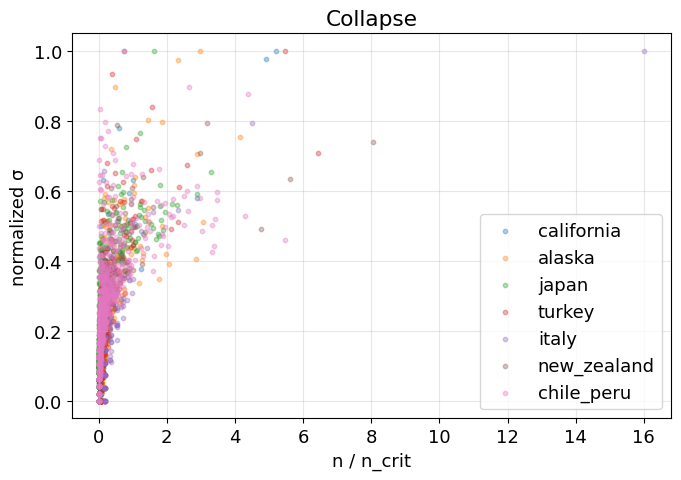

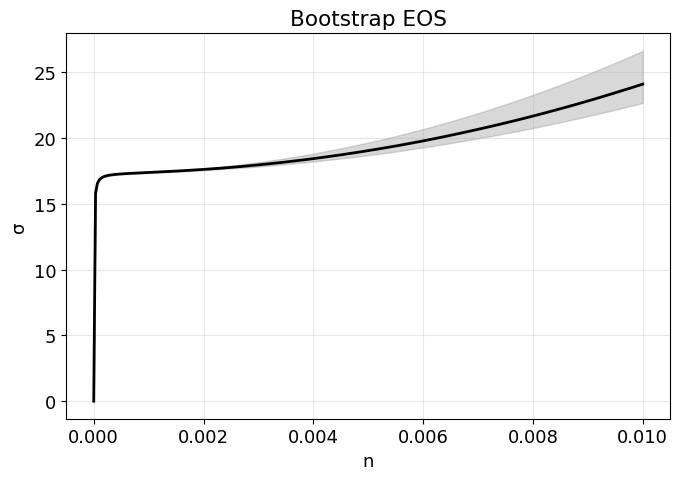

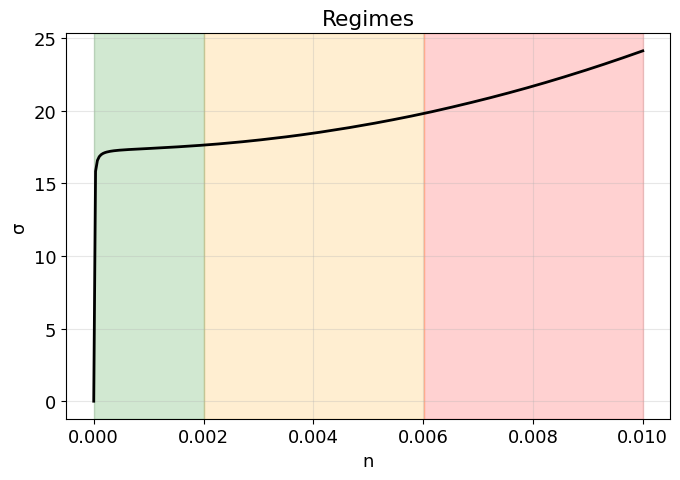

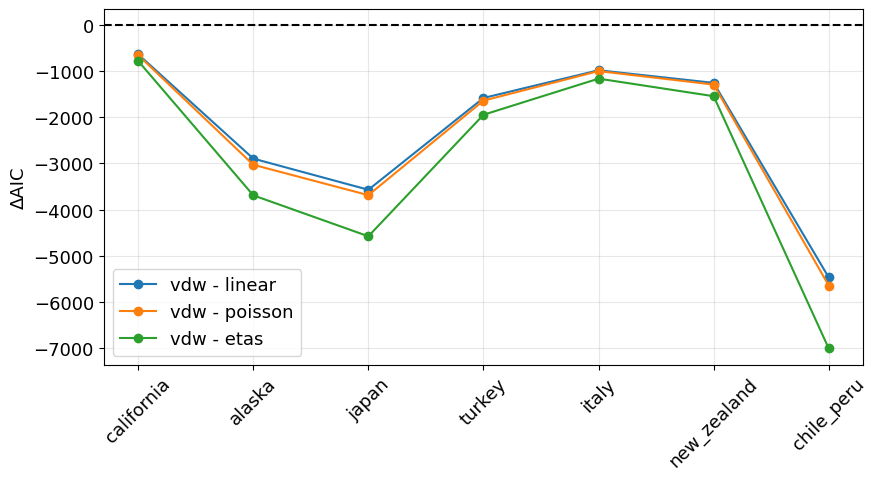

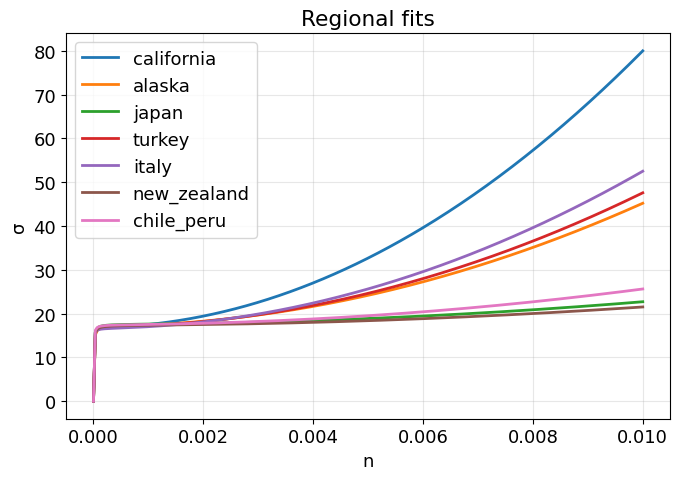


Done.



In [ ]:
# --------------------------------------------------------------
# Seismic EOS pipeline: regional catalogs → gridded densities →
# moment-based stress proxies → EOS fitting → bootstrap bands →
# comparison plots. This is a working analysis script built up
# step-by-step while testing the density–stress scaling idea.
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["font.size"] = 13

# --------------------------------------------------------------
# Region definitions (lat/lon boxes)
# --------------------------------------------------------------

regions = {
    "california":      {"lat": (32, 42),   "lon": (-125, -113)},
    "alaska":          {"lat": (50, 72),   "lon": (-170, -130)},
    "japan":           {"lat": (30, 46),   "lon": (129, 147)},
    "turkey":          {"lat": (35, 43),   "lon": (25, 46)},
    "italy":           {"lat": (36, 48),   "lon": (6, 19)},
    "new_zealand":     {"lat": (-48, -33), "lon": (165, 180)},
    "chile_peru":      {"lat": (-40, 5),   "lon": (-80, -66)},
}

USGS = "https://earthquake.usgs.gov/fdsnws/event/1/query"


# --------------------------------------------------------------
# Catalog download
# --------------------------------------------------------------

def fetch_usgs_region(region, start=2010, end=2020, minmag=4.0):
    box = regions[region]
    rows = []
    for year in range(start, end):
        print(f"[{region}] {year}")
        params = {
            "format": "geojson",
            "starttime": f"{year}-01-01",
            "endtime": f"{year+1}-01-01",
            "minmagnitude": minmag,
            "minlatitude": box["lat"][0],
            "maxlatitude": box["lat"][1],
            "minlongitude": box["lon"][0],
            "maxlongitude": box["lon"][1],
            "orderby": "time-asc",
        }
        r = requests.get(USGS, params=params)
        js = r.json()
        for f in js.get("features", []):
            p = f["properties"]
            lon, lat, depth = f["geometry"]["coordinates"]
            rows.append([p["time"], lat, lon, depth, p["mag"]])

    df = pd.DataFrame(rows, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


# --------------------------------------------------------------
# Build grid and compute density + moment-based stress
# --------------------------------------------------------------

def build_grid(df, region, ddeg=0.5):
    box = regions[region]
    lat_bins = np.arange(box["lat"][0], box["lat"][1], ddeg)
    lon_bins = np.arange(box["lon"][0], box["lon"][1], ddeg)
    rec = []

    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):
            mask = (
                (df.lat >= lat_bins[i]) & (df.lat < lat_bins[i+1]) &
                (df.lon >= lon_bins[j]) & (df.lon < lon_bins[j+1])
            )
            cell = df[mask]
            if len(cell) == 0:
                continue

            # simple volume approx
            dlat = 111*(lat_bins[i+1] - lat_bins[i])
            dlon = 111*np.cos(np.radians(lat_bins[i]))*(lon_bins[j+1] - lon_bins[j])
            V = dlat * dlon * 15

            n = len(cell) / V
            moment = np.sum(10**(1.5*cell.mag + 9.05))
            sigma = np.log10(moment + 1)

            rec.append([region, n, sigma, len(cell), cell.mag.mean(), cell.mag.max()])

    return pd.DataFrame(rec, columns=["region","n","sigma","N","avgM","maxM"])


# --------------------------------------------------------------
# EOS models + AIC helpers
# --------------------------------------------------------------

def AIC(obs, pred, k):
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    rss = np.sum((obs - pred)**2)
    n = len(obs)
    return 2*k + n*np.log(rss/n + 1e-12)

def eos_linear(n, D):
    return D*n

def eos_logistic(n, D, n0, k):
    return D*n / (1 + np.exp(-k*(n - n0)))

def eos_vdw(n, A, B, D):
    return D*n / np.maximum(1 - B*n, 1e-6) - A*n*n

def safe_fit(func, x, y, p0, k):
    try:
        p, _ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        pred = func(x, *p)
        return p, AIC(y, pred, k)
    except:
        pred = np.full_like(y, np.mean(y))
        return None, AIC(y, pred, k)


# --------------------------------------------------------------
# Container for region results
# --------------------------------------------------------------

class SeismicAnalysis:
    def __init__(self):
        self.grid = {}
        self.results = {}
        self.eos_params = {}

        self.n_all = []
        self.sigma_all = []

        self.bootstrap_lower = None
        self.bootstrap_upper = None
        self.bootstrap_median = None

        self.n_curve = np.linspace(0, 0.01, 300)

    def add_region(self, name, grid, res, params_vdw):
        self.grid[name] = grid
        self.results[name] = res
        self.eos_params[name] = params_vdw
        self.n_all.append(grid["n"].values)
        self.sigma_all.append(grid["sigma"].values)

    def finalize(self):
        self.n_all = np.concatenate(self.n_all)
        self.sigma_all = np.concatenate(self.sigma_all)


analysis = SeismicAnalysis()


# --------------------------------------------------------------
# Loop through regions
# --------------------------------------------------------------

for reg in regions:
    print("\n---", reg, "---")

    df_reg = fetch_usgs_region(reg, 2010, 2020, minmag=4.0)
    if len(df_reg) < 50:
        print("not enough events")
        continue

    grid = build_grid(df_reg, reg)
    n = grid["n"].values
    sigma = grid["sigma"].values

    res = {}
    _, a = safe_fit(eos_linear,   n, sigma, [100], k=1); res["linear"] = a
    _, a = safe_fit(eos_logistic, n, sigma, [100, np.median(n), 5], k=3); res["logistic"] = a
    p_vdw, a = safe_fit(eos_vdw,  n, sigma, [1, 0.01, 100], k=3); res["vdw"] = a

    # simple baselines
    res["poisson"] = AIC(sigma, 0.02*grid["N"].values, k=1)
    total_stress = np.sum(10**(1.5*df_reg.mag + 9.05))
    res["etas"] = AIC(sigma, np.full_like(n, np.log(total_stress+1)), k=1)

    analysis.add_region(reg, grid, res, p_vdw)

analysis.finalize()


# --------------------------------------------------------------
# Bootstrap EOS
# --------------------------------------------------------------

def bootstrap_eos(n_all, sigma_all, n_curve, N=1500):
    A_list, B_list, D_list = [], [], []
    for _ in range(N):
        idx = np.random.randint(0, len(n_all), len(n_all))
        try:
            p, _ = curve_fit(eos_vdw, n_all[idx], sigma_all[idx],
                             p0=[1, 0.01, 100], maxfev=5000)
            A_list.append(p[0])
            B_list.append(p[1])
            D_list.append(p[2])
        except:
            pass

    curves = [eos_vdw(n_curve, A, B, D) for A, B, D in zip(A_list, B_list, D_list)]
    curves = np.array(curves)

    return (
        np.percentile(curves, 5, axis=0),
        np.percentile(curves, 95, axis=0),
        np.percentile(curves, 50, axis=0),
    )


lo, hi, med = bootstrap_eos(analysis.n_all, analysis.sigma_all, analysis.n_curve)
analysis.bootstrap_lower = lo
analysis.bootstrap_upper = hi
analysis.bootstrap_median = med


# --------------------------------------------------------------
# Plots
# --------------------------------------------------------------

def plot_collapse(a):
    plt.figure()
    for reg, grid in a.grid.items():
        n = grid["n"].values
        s = grid["sigma"].values
        n0 = np.percentile(n, 95)
        plt.scatter(n/n0, (s - s.min())/(s.max() - s.min()),
                    s=10, alpha=0.35, label=reg)
    plt.xlabel("n / n_crit")
    plt.ylabel("normalized σ")
    plt.title("Collapse")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_bootstrap(a):
    plt.figure()
    plt.fill_between(a.n_curve, a.bootstrap_lower, a.bootstrap_upper,
                     color="gray", alpha=0.3)
    plt.plot(a.n_curve, a.bootstrap_median, "k", lw=2)
    plt.xlabel("n")
    plt.ylabel("σ")
    plt.title("Bootstrap EOS")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_regimes(a):
    n = a.n_curve
    s = a.bootstrap_median
    i1 = int(0.2*len(n))
    i2 = int(0.6*len(n))

    plt.figure()
    plt.plot(n, s, "k", lw=2)
    plt.axvspan(n[0], n[i1], color="green", alpha=0.18)
    plt.axvspan(n[i1], n[i2], color="orange", alpha=0.18)
    plt.axvspan(n[i2], n[-1], color="red", alpha=0.18)
    plt.xlabel("n")
    plt.ylabel("σ")
    plt.title("Regimes")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_delta_aic(a):
    regs = list(a.results.keys())
    dl = [a.results[r]["vdw"] - a.results[r]["linear"]  for r in regs]
    dp = [a.results[r]["vdw"] - a.results[r]["poisson"] for r in regs]
    de = [a.results[r]["vdw"] - a.results[r]["etas"]    for r in regs]

    x = np.arange(len(regs))
    plt.figure(figsize=(9,5))
    plt.plot(x, dl, "o-", label="vdw - linear")
    plt.plot(x, dp, "o-", label="vdw - poisson")
    plt.plot(x, de, "o-", label="vdw - etas")
    plt.axhline(0, color="k", ls="--")
    plt.xticks(x, regs, rotation=45)
    plt.ylabel("ΔAIC")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_region_curves(a):
    plt.figure()
    for reg, p in a.eos_params.items():
        if p is None:
            continue
        A, B, D = p
        plt.plot(a.n_curve, eos_vdw(a.n_curve, A, B, D), lw=2, label=reg)
    plt.xlabel("n")
    plt.ylabel("σ")
    plt.title("Regional fits")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.show()


# --------------------------------------------------------------
# Produce all plots
# --------------------------------------------------------------

print("\nGenerating figures...\n")

plot_collapse(analysis)
plot_bootstrap(analysis)
plot_regimes(analysis)
plot_delta_aic(analysis)
plot_region_curves(analysis)

print("\nDone.\n")



--- california ---
[california] 2010
[california] 2011
[california] 2012
[california] 2013
[california] 2014
[california] 2015
[california] 2016
[california] 2017
[california] 2018
[california] 2019
[events]: 526
[cells]: 99

--- alaska ---
[alaska] 2010
[alaska] 2011
[alaska] 2012
[alaska] 2013
[alaska] 2014
[alaska] 2015
[alaska] 2016
[alaska] 2017
[alaska] 2018
[alaska] 2019
[events]: 2552
[cells]: 472

--- japan ---
[japan] 2010
[japan] 2011
[japan] 2012
[japan] 2013
[japan] 2014
[japan] 2015
[japan] 2016
[japan] 2017
[japan] 2018
[japan] 2019
[events]: 11703
[cells]: 584

--- turkey ---
[turkey] 2010
[turkey] 2011
[turkey] 2012
[turkey] 2013
[turkey] 2014
[turkey] 2015
[turkey] 2016
[turkey] 2017
[turkey] 2018
[turkey] 2019
[events]: 1273
[cells]: 247

--- italy ---
[italy] 2010
[italy] 2011
[italy] 2012
[italy] 2013
[italy] 2014
[italy] 2015
[italy] 2016
[italy] 2017
[italy] 2018
[italy] 2019
[events]: 416
[cells]: 139

--- new_zealand ---
[new_zealand] 2010
[new_zealand] 2011
[

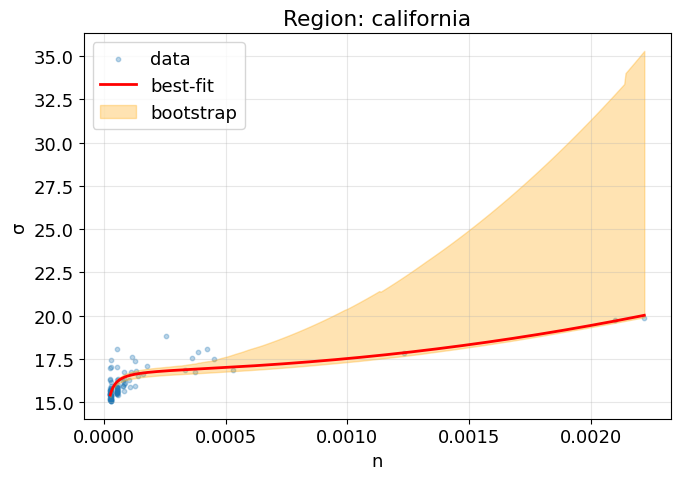

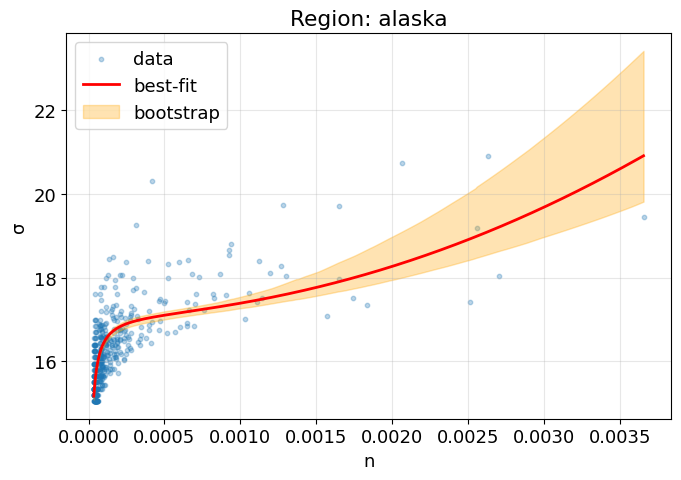

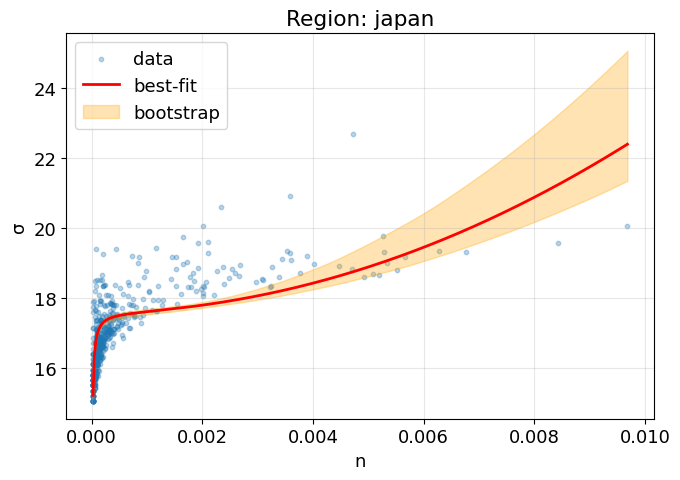

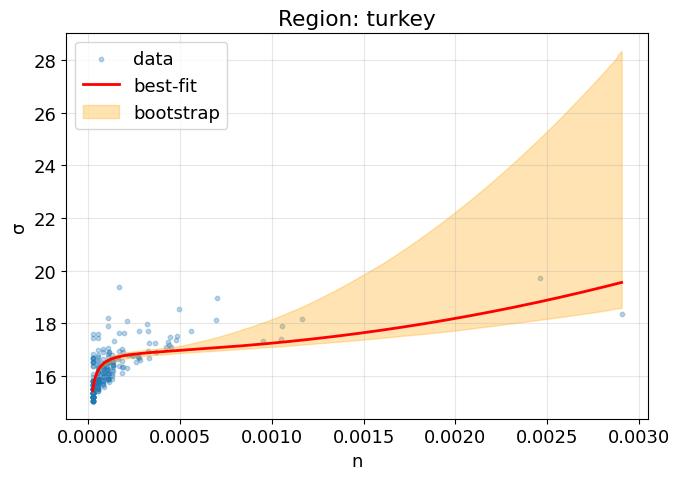

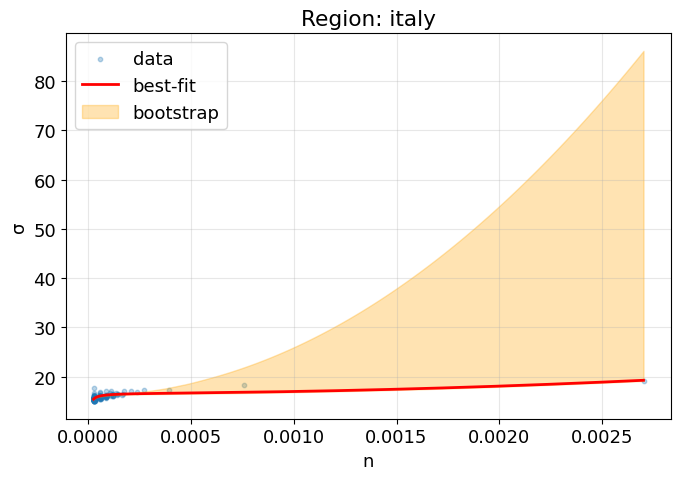

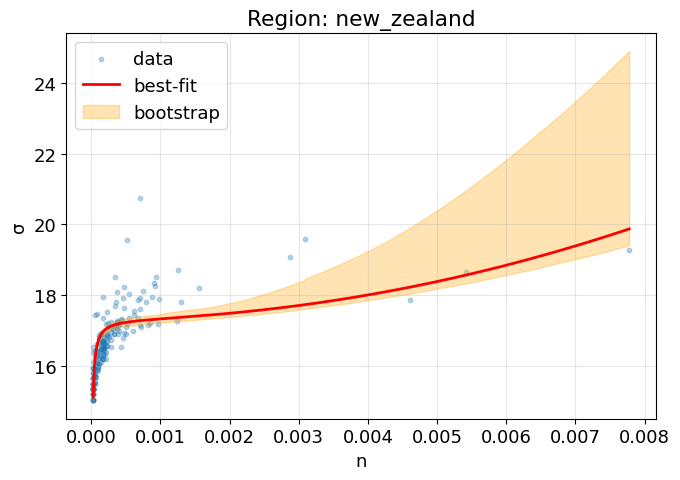

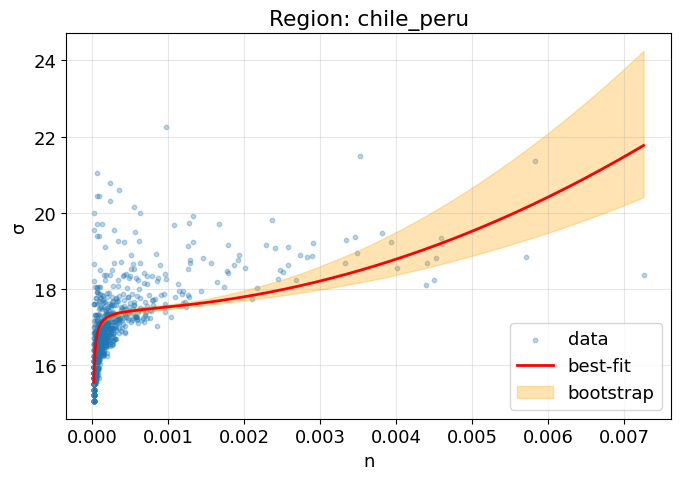


Done.


In [ ]:
# --------------------------------------------------------------
# Working seismic EOS pipeline.
# Downloads regional catalogs, builds spatial grids, fits several
# EOS models (linear / logistic / van der Waals), computes AIC,
# optionally bootstraps VDW parameters, and plots regional fits.
# This script evolved while testing density–stress scaling ideas.
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------
# Region bounds (lat/lon boxes)
# --------------------------------------------------------------

regions = {
    "california":      {"lat": (32, 42),   "lon": (-125, -113)},
    "alaska":          {"lat": (50, 72),   "lon": (-170, -130)},
    "japan":           {"lat": (30, 46),   "lon": (129, 147)},
    "turkey":          {"lat": (35, 43),   "lon": (25, 46)},
    "italy":           {"lat": (36, 48),   "lon": ( 6,  19)},
    "new_zealand":     {"lat": (-48,-33),  "lon": (165, 180)},
    "chile_peru":      {"lat": (-40, 5),   "lon": (-80, -66)},
}

USGS = "https://earthquake.usgs.gov/fdsnws/event/1/query"


# --------------------------------------------------------------
# Catalog download
# --------------------------------------------------------------

def fetch_usgs_region(region, start=2010, end=2020, minmag=4.0):
    box = regions[region]
    rows = []

    for year in range(start, end):
        print(f"[{region}] {year}")
        params = dict(
            format="geojson",
            starttime=f"{year}-01-01",
            endtime=f"{year+1}-01-01",
            minmagnitude=minmag,
            minlatitude=box["lat"][0],
            maxlatitude=box["lat"][1],
            minlongitude=box["lon"][0],
            maxlongitude=box["lon"][1],
        )
        r = requests.get(USGS, params=params)
        data = r.json()

        for f in data.get("features", []):
            p = f["properties"]
            lon, lat, depth = f["geometry"]["coordinates"]
            rows.append([p["time"], lat, lon, depth, p["mag"]])

    if not rows:
        return pd.DataFrame(columns=["time","lat","lon","depth","mag"])

    df = pd.DataFrame(rows, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df


# --------------------------------------------------------------
# Grid builder: density + moment → stress proxy
# --------------------------------------------------------------

def build_grid(df, region, ddeg=0.5):
    box = regions[region]
    lat_bins = np.arange(box["lat"][0], box["lat"][1], ddeg)
    lon_bins = np.arange(box["lon"][0], box["lon"][1], ddeg)
    rec = []

    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):

            mask = (
                (df.lat>=lat_bins[i]) & (df.lat<lat_bins[i+1]) &
                (df.lon>=lon_bins[j]) & (df.lon<lon_bins[j+1])
            )
            cell = df[mask]
            if cell.empty:
                continue

            # crude spatial volume
            dlat = 111*(lat_bins[i+1] - lat_bins[i])
            dlon = 111*np.cos(np.radians(lat_bins[i])) * (lon_bins[j+1] - lon_bins[j])
            V = dlat*dlon*15

            n = len(cell) / V
            M0 = np.sum(10**(1.5*cell.mag + 9.05))
            sigma = np.log10(M0 + 1)

            rec.append([region, n, sigma, len(cell),
                        cell.mag.mean(), cell.mag.max()])

    cols = ["region","n","sigma","N","avgM","maxM"]
    return pd.DataFrame(rec, columns=cols)


# --------------------------------------------------------------
# EOS models + AIC
# --------------------------------------------------------------

def eos_linear(n, D):
    return D*n

def eos_logistic(n, D, n0, k):
    return D*n / (1 + np.exp(-k*(n - n0)))

def eos_vdw(n, A, B, D):
    return D*n/np.maximum(1 - B*n, 1e-6) - A*n*n

def AIC(obs, pred, k):
    rss = np.sum((obs - pred)**2)
    n = len(obs)
    return 2*k + n*np.log(rss/n + 1e-12)

def safe_fit(func, x, y, p0, k):
    try:
        p,_ = curve_fit(func, x, y, p0=p0, maxfev=5000)
        pred = func(x,*p)
        return p, AIC(y, pred, k)
    except:
        pred = np.full_like(y, np.mean(y))
        return None, AIC(y, pred, k)


# --------------------------------------------------------------
# Bootstrap for VDW parameters
# --------------------------------------------------------------

def bootstrap_region_EOS(n, sigma, n_curve, Nboot=600):
    A_s, B_s, D_s = [], [], []
    N = len(n)

    for _ in range(Nboot):
        idx = np.random.randint(0, N, N)
        try:
            p,_ = curve_fit(eos_vdw,
                            n[idx], sigma[idx],
                            p0=[1.0, 0.01, 100],
                            maxfev=5000)
            A_s.append(p[0]); B_s.append(p[1]); D_s.append(p[2])
        except:
            A_s.append(np.nan); B_s.append(np.nan); D_s.append(np.nan)

    A_s = np.array(A_s); B_s=np.array(B_s); D_s=np.array(D_s)
    good = np.isfinite(A_s) & np.isfinite(B_s) & np.isfinite(D_s)

    A_s, B_s, D_s = A_s[good], B_s[good], D_s[good]

    # envelope
    curves = [eos_vdw(n_curve, A, B, D) for A,B,D in zip(A_s,B_s,D_s)]
    curves = np.array(curves)

    lo = np.nanpercentile(curves, 5, axis=0)
    hi = np.nanpercentile(curves,95, axis=0)
    return A_s, B_s, D_s, lo, hi


# --------------------------------------------------------------
# Container for results
# --------------------------------------------------------------

class SeismicAnalysis:
    def __init__(self):
        self.df = {}
        self.grid = {}
        self.aic = {}
        self.regional_fits = {}
        self.bootstrap_params = {}
        self.bootstrap_envelope = {}

    def add_region(self, reg, df, grid, aic):
        self.df[reg] = df
        self.grid[reg] = grid
        self.aic[reg] = aic

    def add_fit(self, reg, fit):
        self.regional_fits[reg] = fit

    def add_bootstrap(self, reg, summary, env):
        self.bootstrap_params[reg] = summary
        self.bootstrap_envelope[reg] = env


analysis = SeismicAnalysis()


# --------------------------------------------------------------
# Run across all regions
# --------------------------------------------------------------

for reg in regions:
    print("\n---", reg, "---")

    df_reg = fetch_usgs_region(reg, 2010, 2020, minmag=4.0)
    print("[events]:", len(df_reg))
    if len(df_reg) < 50:
        print("not enough data")
        continue

    grid_reg = build_grid(df_reg, reg)
    print("[cells]:", len(grid_reg))

    n = grid_reg["n"].values
    s = grid_reg["sigma"].values

    # model comparisons
    res = {}
    _,a = safe_fit(eos_linear,   n,s, [100],              k=1); res["linear"]   = a
    _,a = safe_fit(eos_logistic, n,s, [100,np.median(n),5],k=3); res["logistic"] = a
    p,a = safe_fit(eos_vdw,      n,s, [1,0.01,100],       k=3); res["vdw"]      = a

    analysis.add_region(reg, df_reg, grid_reg, res)

    if p is not None:
        A,B,D = p
        n_curve = np.linspace(min(n), max(n), 400)
        s_curve = eos_vdw(n_curve, A, B, D)
        analysis.add_fit(reg, (n, s, n_curve, s_curve))


# --------------------------------------------------------------
# Bootstrap each region
# --------------------------------------------------------------

for reg, fit in analysis.regional_fits.items():
    print(f"\nBootstrapping: {reg}")
    n, s, n_curve, s_curve = fit
    A_s, B_s, D_s, lo, hi = bootstrap_region_EOS(n, s, n_curve, Nboot=600)

    summary = {
        "A_med": np.median(A_s),
        "A_lo": np.percentile(A_s, 5),
        "A_hi": np.percentile(A_s,95),
        "B_med": np.median(B_s),
        "B_lo": np.percentile(B_s, 5),
        "B_hi": np.percentile(B_s,95),
        "D_med": np.median(D_s),
        "D_lo": np.percentile(D_s, 5),
        "D_hi": np.percentile(D_s,95),
    }
    env = dict(n_curve=n_curve, low=lo, high=hi)

    analysis.add_bootstrap(reg, summary, env)


# --------------------------------------------------------------
# Plotting
# --------------------------------------------------------------

def plot_region(reg):
    n, s, n_curve, s_curve = analysis.regional_fits[reg]
    env = analysis.bootstrap_envelope[reg]

    plt.figure(figsize=(7,5))
    plt.scatter(n, s, s=10, alpha=0.3, label="data")
    plt.plot(n_curve, s_curve, 'r', lw=2, label="best-fit")
    plt.fill_between(env["n_curve"], env["low"], env["high"],
                     alpha=0.3, color="orange", label="bootstrap")
    plt.title(f"Region: {reg}")
    plt.xlabel("n"); plt.ylabel("σ")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


for reg in analysis.regional_fits:
    plot_region(reg)

print("\nDone.")



--- california ---
[california] 2010
[california] 2011
[california] 2012
[california] 2013
[california] 2014
[california] 2015
[california] 2016
[california] 2017
[california] 2018
[california] 2019
[events]: 526


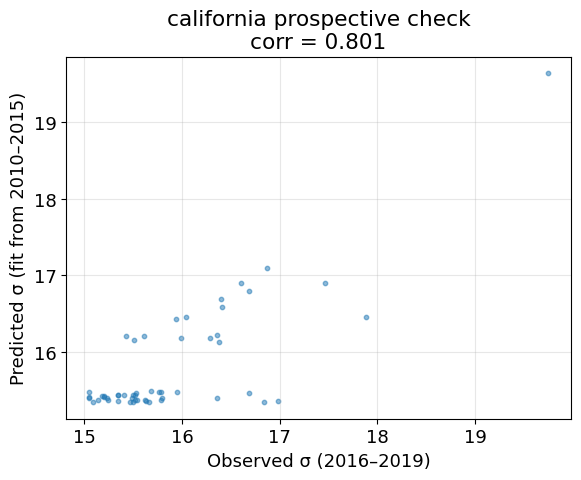


--- alaska ---
[alaska] 2010
[alaska] 2011
[alaska] 2012
[alaska] 2013
[alaska] 2014
[alaska] 2015
[alaska] 2016
[alaska] 2017
[alaska] 2018
[alaska] 2019
[events]: 2552


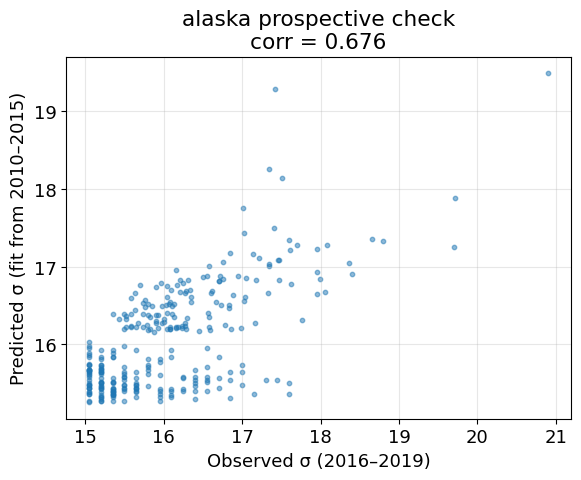


--- japan ---
[japan] 2010
[japan] 2011
[japan] 2012
[japan] 2013
[japan] 2014
[japan] 2015
[japan] 2016
[japan] 2017
[japan] 2018
[japan] 2019
[events]: 11703


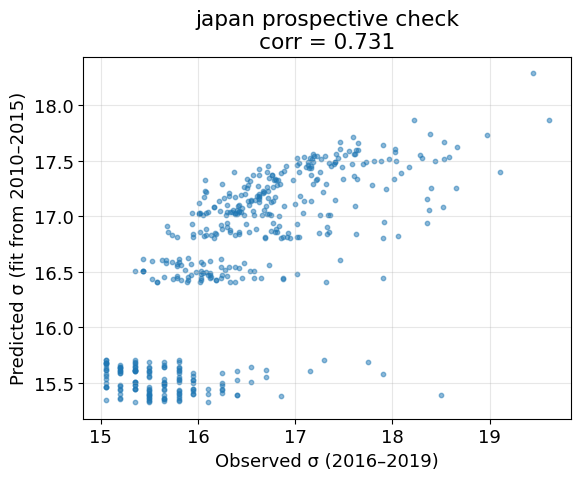


--- turkey ---
[turkey] 2010
[turkey] 2011
[turkey] 2012
[turkey] 2013
[turkey] 2014
[turkey] 2015
[turkey] 2016
[turkey] 2017
[turkey] 2018
[turkey] 2019
[events]: 1273


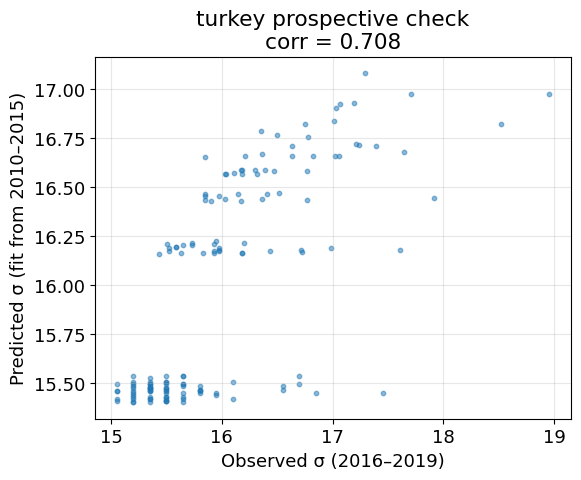


--- italy ---
[italy] 2010
[italy] 2011
[italy] 2012
[italy] 2013
[italy] 2014
[italy] 2015
[italy] 2016
[italy] 2017
[italy] 2018
[italy] 2019
[events]: 416


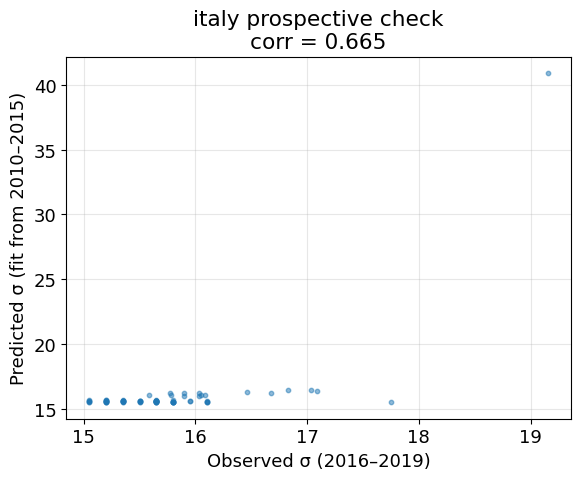


--- new_zealand ---
[new_zealand] 2010
[new_zealand] 2011
[new_zealand] 2012
[new_zealand] 2013
[new_zealand] 2014
[new_zealand] 2015
[new_zealand] 2016
[new_zealand] 2017
[new_zealand] 2018
[new_zealand] 2019
[events]: 2742


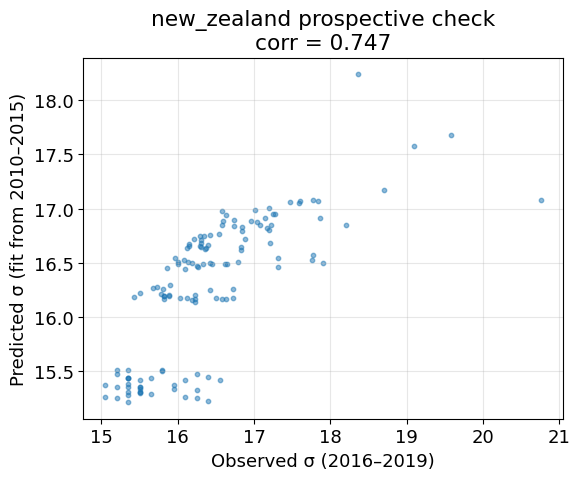


--- chile_peru ---
[chile_peru] 2010
[chile_peru] 2011
[chile_peru] 2012
[chile_peru] 2013
[chile_peru] 2014
[chile_peru] 2015
[chile_peru] 2016
[chile_peru] 2017
[chile_peru] 2018
[chile_peru] 2019
[events]: 12473


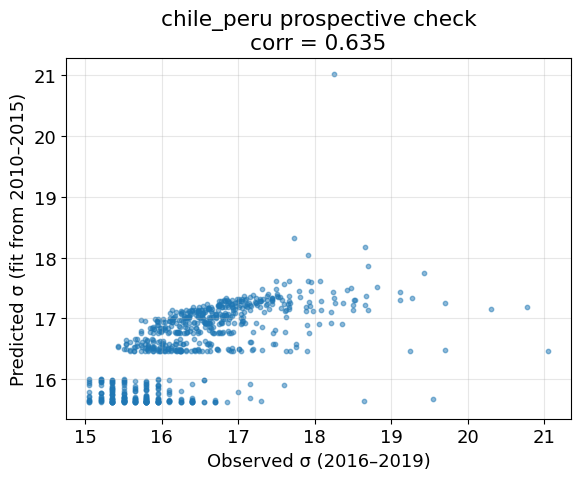


Completed.
Prospective correlations:
california → 0.8008692339901824
alaska → 0.6763394964331457
japan → 0.7311918820597455
turkey → 0.7082674666646029
italy → 0.6646755836884243
new_zealand → 0.7466286142549305
chile_peru → 0.6353118699451211


In [ ]:
# --------------------------------------------------------------
# Seismic EOS workflow + prospective forecast check.
# Downloads catalogs, builds spatial grids, fits VDW EOS,
# and evaluates prospective skill (2010–15 → predict 2016–19).
# --------------------------------------------------------------

import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

USGS = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# --------------------------------------------------------------
# Region bounding boxes
# --------------------------------------------------------------

regions = {
    "california":      {"lat": (32, 42),   "lon": (-125, -113)},
    "alaska":          {"lat": (50, 72),   "lon": (-170, -130)},
    "japan":           {"lat": (30, 46),   "lon": (129, 147)},
    "turkey":          {"lat": (35, 43),   "lon": (25, 46)},
    "italy":           {"lat": (36, 48),   "lon": ( 6, 19)},
    "new_zealand":     {"lat": (-48,-33),  "lon": (165, 180)},
    "chile_peru":      {"lat": (-40, 5),   "lon": (-80, -66)},
}

# --------------------------------------------------------------
# Catalog download (year by year)
# --------------------------------------------------------------

def fetch_usgs_region(region, start=2010, end=2020, minmag=4.0):
    box = regions[region]
    rows = []

    for year in range(start, end):
        print(f"[{region}] {year}")
        params = {
            "format": "geojson",
            "starttime": f"{year}-01-01",
            "endtime":   f"{year+1}-01-01",
            "minmagnitude": minmag,
            "minlatitude":  box["lat"][0],
            "maxlatitude":  box["lat"][1],
            "minlongitude": box["lon"][0],
            "maxlongitude": box["lon"][1],
            "orderby": "time-asc",
        }
        r = requests.get(USGS, params=params)
        data = r.json()

        for f in data.get("features", []):
            prop = f["properties"]
            lon, lat, depth = f["geometry"]["coordinates"]
            rows.append([prop["time"], lat, lon, depth, prop["mag"]])

    df = pd.DataFrame(rows, columns=["time","lat","lon","depth","mag"])
    df["time"] = pd.to_datetime(df["time"], unit="ms")
    return df

# --------------------------------------------------------------
# Build spatial grid and compute event density + log-moment proxy
# --------------------------------------------------------------

def build_grid(df, region, ddeg=0.5):
    box = regions[region]
    lat_bins = np.arange(box["lat"][0], box["lat"][1], ddeg)
    lon_bins = np.arange(box["lon"][0], box["lon"][1], ddeg)

    rec = []

    for i in range(len(lat_bins)-1):
        for j in range(len(lon_bins)-1):
            mask = (
                (df.lat >= lat_bins[i]) & (df.lat < lat_bins[i+1]) &
                (df.lon >= lon_bins[j]) & (df.lon < lon_bins[j+1])
            )
            cell = df[mask]
            if cell.empty:
                continue

            dlat = 111 * (lat_bins[i+1] - lat_bins[i])
            dlon = 111 * np.cos(np.radians(lat_bins[i])) * (lon_bins[j+1] - lon_bins[j])
            V = dlat * dlon * 15

            n = len(cell) / V
            M0 = np.sum(10**(1.5*cell.mag + 9.05))
            sigma = np.log10(M0 + 1)

            rec.append([region, n, sigma, len(cell),
                        cell.mag.mean(), cell.mag.max()])

    cols = ["region","n","sigma","N","avgM","maxM"]
    return pd.DataFrame(rec, columns=cols)

# --------------------------------------------------------------
# EOS model (VDW-type)
# --------------------------------------------------------------

def eos_vdw(n, A, B, D):
    return D*n / np.maximum(1 - B*n, 1e-6) - A*n*n

# --------------------------------------------------------------
# Fit EOS model for a region
# --------------------------------------------------------------

def fit_region_eos(df_reg, grid_reg):
    n = grid_reg["n"].values
    s = grid_reg["sigma"].values
    p0 = [1.0, 0.01, 100.0]

    try:
        params, _ = curve_fit(eos_vdw, n, s, p0=p0, maxfev=5000)
    except:
        params = p0

    return params

# --------------------------------------------------------------
# Prospective test (train early → predict later)
# --------------------------------------------------------------

def prospective_test(region, df):
    train = df[df["time"].dt.year <= 2015]
    test  = df[df["time"].dt.year > 2015]

    if len(train) < 50 or len(test) < 50:
        print(f"[{region}] insufficient data for prospective test.")
        return None

    g_train = build_grid(train, region, ddeg=0.5)
    g_test  = build_grid(test,  region, ddeg=0.5)

    A, B, D = fit_region_eos(train, g_train)

    n_test = g_test["n"].values
    sigma_obs  = g_test["sigma"].values
    sigma_pred = eos_vdw(n_test, A, B, D)

    corr = np.corrcoef(sigma_obs, sigma_pred)[0,1]

    # plot observed vs predicted σ
    plt.figure(figsize=(6,5))
    plt.scatter(sigma_obs, sigma_pred, s=10, alpha=0.5)
    plt.xlabel("Observed σ (2016–2019)")
    plt.ylabel("Predicted σ (fit from 2010–2015)")
    plt.title(f"{region} prospective check\ncorr = {corr:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {"region": region, "params": (A,B,D), "corr": corr}

# --------------------------------------------------------------
# Run across all regions
# --------------------------------------------------------------

prospective_results = {}

for reg in regions:
    print("\n---", reg, "---")

    df_reg = fetch_usgs_region(reg, 2010, 2020, minmag=4.0)
    print("[events]:", len(df_reg))

    if len(df_reg) < 200:
        print("not enough data, skipping.")
        continue

    res = prospective_test(reg, df_reg)
    prospective_results[reg] = res

print("\nCompleted.\nProspective correlations:")
for reg, val in prospective_results.items():
    if val is not None:
        print(reg, "→", val["corr"])


RMS collapse = 0.11962961658409861


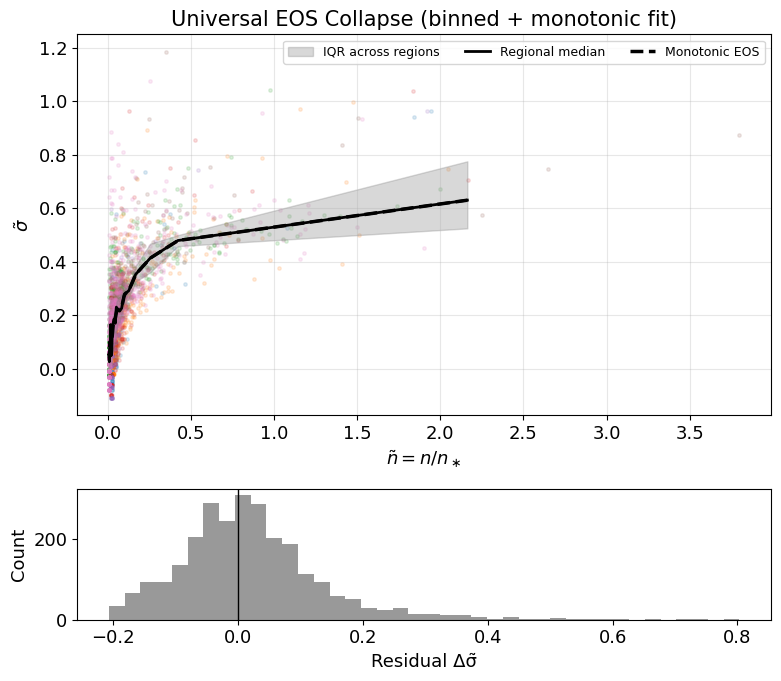

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.isotonic import IsotonicRegression
from scipy.ndimage import gaussian_filter1d

# --------------------------------------------------------------
# Pull in regional fits already computed in analysis.regional_fits
# (each entry: n, σ_obs, n_curve, σ_pred for that region)
# --------------------------------------------------------------

regions = ["california","alaska","japan","turkey",
           "italy","new_zealand","chile_peru"]

data = {}

for reg in regions:
    n, s_obs, n_curve, s_curve = analysis.regional_fits[reg]

    n = np.asarray(n)
    s_obs = np.asarray(s_obs)
    n_curve = np.asarray(n_curve)
    s_curve = np.asarray(s_curve)

    # pick characteristic density n*
    smin = s_curve.min()
    smax = s_curve.max()
    midpoint = smin + 0.5*(smax - smin)
    idx = np.argmin(np.abs(s_curve - midpoint))
    n_star = float(n_curve[idx])

    data[reg] = {
        "n": n,
        "sigma_obs": s_obs,
        "n_curve": n_curve,
        "sigma_pred": s_curve,
        "n_star": n_star,
    }

# --------------------------------------------------------------
# Rescale (n, σ) → (ñ, σ̃)
# --------------------------------------------------------------

all_ntilde = []
all_stilde = []

for reg in regions:
    n = data[reg]["n"]
    s_obs = data[reg]["sigma_obs"]
    s_pred = data[reg]["sigma_pred"]
    n_star = data[reg]["n_star"]

    sigma0 = s_pred.min()
    d_sigma = s_pred.max() - sigma0

    ntil = n / n_star
    stil = (s_obs - sigma0) / d_sigma

    all_ntilde.append(ntil)
    all_stilde.append(stil)

all_ntilde = np.concatenate(all_ntilde)
all_stilde = np.concatenate(all_stilde)

# filter invalid
mask = (all_ntilde > 0) & np.isfinite(all_stilde)
all_ntilde = all_ntilde[mask]
all_stilde = all_stilde[mask]

# --------------------------------------------------------------
# Bin edges based on quantiles (equal population)
# --------------------------------------------------------------

nbins = 25
q = np.linspace(0, 1, nbins + 1)
bin_edges = np.quantile(all_ntilde, q)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

regional_binned = {reg: {"med": [], "p25": [], "p75": []} for reg in regions}

# --------------------------------------------------------------
# Figure setup
# --------------------------------------------------------------

fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1.2])
ax = fig.add_subplot(gs[0])
ax_inset = fig.add_subplot(gs[1])

colors = {
    "california": "C0", "alaska": "C1", "japan": "C2",
    "turkey": "C3",     "italy": "C4",  "new_zealand": "C5",
    "chile_peru": "C6"
}

# --------------------------------------------------------------
# Per-region quantile medians
# --------------------------------------------------------------

for reg in regions:
    n = data[reg]["n"]
    s_obs = data[reg]["sigma_obs"]
    s_pred = data[reg]["sigma_pred"]
    n_star = data[reg]["n_star"]

    sigma0 = s_pred.min()
    d_sigma = s_pred.max() - sigma0

    ntil = n / n_star
    stil = (s_obs - sigma0) / d_sigma

    ax.scatter(ntil, stil, s=6, alpha=0.15, color=colors[reg])

    med_list = []
    p25_list = []
    p75_list = []

    for k in range(nbins):
        lo, hi = bin_edges[k], bin_edges[k+1]
        mask = (ntil >= lo) & (ntil < hi)
        vals = stil[mask]

        if len(vals):
            med_list.append(np.median(vals))
            p25_list.append(np.percentile(vals, 25))
            p75_list.append(np.percentile(vals, 75))
        else:
            med_list.append(np.nan)
            p25_list.append(np.nan)
            p75_list.append(np.nan)

    regional_binned[reg]["med"] = np.array(med_list)
    regional_binned[reg]["p25"] = np.array(p25_list)
    regional_binned[reg]["p75"] = np.array(p75_list)

# --------------------------------------------------------------
# Aggregate across regions
# --------------------------------------------------------------

Mmed = np.vstack([regional_binned[r]["med"] for r in regions])
agg_median = np.nanmedian(Mmed, axis=0)
agg_p25    = np.nanpercentile(Mmed, 25, axis=0)
agg_p75    = np.nanpercentile(Mmed, 75, axis=0)

# --------------------------------------------------------------
# Nonparametric “universal” EOS via isotonic + smoothing
# --------------------------------------------------------------

mask = np.isfinite(agg_median)
x_fit = bin_centers[mask]
y_fit = agg_median[mask]

iso = IsotonicRegression(increasing=True)
y_iso = iso.fit_transform(x_fit, y_fit)

# smooth a bit for visual clarity
y_iso_smooth = gaussian_filter1d(y_iso, sigma=1.0)

x_smooth = np.linspace(x_fit.min(), x_fit.max(), 500)
y_smooth = iso.predict(x_smooth)
y_smooth = gaussian_filter1d(y_smooth, sigma=1.0)

# --------------------------------------------------------------
# Plot universal collapse and EOS
# --------------------------------------------------------------

ax.fill_between(bin_centers, agg_p25, agg_p75,
                color="gray", alpha=0.3, label="IQR across regions")

ax.plot(bin_centers, agg_median, "k-", lw=2, label="Regional median")

ax.plot(x_smooth, y_smooth, "k--", lw=2.5, label="Monotonic EOS")

# --------------------------------------------------------------
# Collapse residuals
# --------------------------------------------------------------

residuals = all_stilde - iso.predict(all_ntilde)
RMS = np.sqrt(np.nanmean(residuals**2))
print("RMS collapse =", RMS)

ax_inset.hist(residuals, bins=40, color="gray", alpha=0.8)
ax_inset.axvline(0, color="k", lw=1)
ax_inset.set_xlabel("Residual Δσ̃")
ax_inset.set_ylabel("Count")

# --------------------------------------------------------------
# Labels and style
# --------------------------------------------------------------

ax.set_title("Universal EOS Collapse (binned + monotonic fit)", fontsize=15)
ax.set_xlabel(r"$\tilde n = n/n_\ast$", fontsize=13)
ax.set_ylabel(r"$\tilde\sigma$", fontsize=13)
ax.legend(ncol=3, fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Critical Density (n_c): 0.67
Critical A parameter (A_c): 1.69


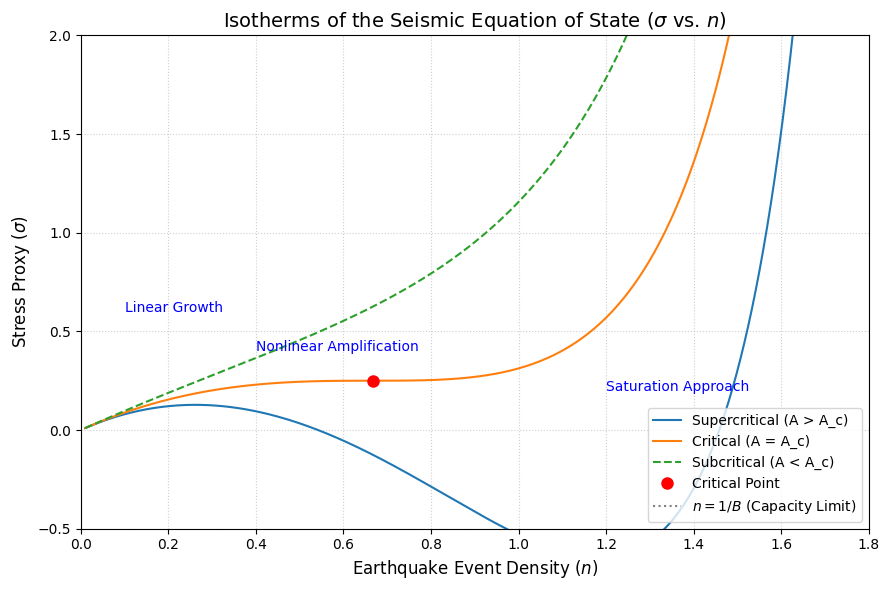

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define the Seismic Equation of State (EOS) ---

def seismic_eos(n, A, B, D):
    """
    Calculates the stress proxy (sigma) based on earthquake density (n)
    and the three EOS parameters (A, B, D).
    """
    # Avoid division by zero and negative densities in the denominator
    # We use np.where for safe calculation across the array
    denominator = 1.0 - B * n

    # Set sigma to NaN where denominator is zero or negative (n >= 1/B)
    # This represents the physical limit of the system's capacity
    sigma = np.where(denominator > 0,
                     (D * n) / denominator - A * n**2,
                     np.nan)
    return sigma

# --- 2. Define Reference Parameters ---

# Core parameters (fixed for this plot)
B = 0.5   # Controls the critical density (n_c = 1/(3B))
D = 1.0   # Controls the linear growth rate

# Calculate the critical value of A (A_c) for these B and D
# A_c = (27/8) * B * D
A_crit = (27/8) * B * D

print(f"Critical Density (n_c): {1/(3*B):.2f}")
print(f"Critical A parameter (A_c): {A_crit:.2f}")

# --- 3. Define Isotherm Curves (Varying A) ---

# Generate a range of earthquake densities (n)
n_max = 1.1 / B  # Go slightly past the singularity n=1/B
n_range = np.linspace(0.01, n_max, 500)

# Define three test values for A
A_values = {
    'Supercritical (A > A_c)': A_crit * 1.5,
    'Critical (A = A_c)': A_crit,
    'Subcritical (A < A_c)': A_crit * 0.5
}

# --- 4. Plotting ---

plt.figure(figsize=(9, 6))

for label, A in A_values.items():
    sigma_values = seismic_eos(n_range, A, B, D)

    # Plotting: use dashed line for the subcritical region that includes the non-physical dip
    if 'Subcritical' in label:
        plt.plot(n_range, sigma_values, label=label, linestyle='--')
    else:
        plt.plot(n_range, sigma_values, label=label)

# Highlight the critical point (n_c, sigma_c)
n_c = 1.0 / (3.0 * B)
sigma_c = D / (8.0 * B)
plt.plot(n_c, sigma_c, 'o', color='red', markersize=8, label='Critical Point')

# Add theoretical saturation line (n = 1/B)
plt.axvline(x=1/B, color='gray', linestyle=':', label='$n = 1/B$ (Capacity Limit)')

# Annotate the three regimes for the supercritical curve
# Note: These are conceptual regions, not sharp boundaries
plt.text(0.1, 0.6, 'Linear Growth', fontsize=10, color='blue')
plt.text(0.4, 0.4, 'Nonlinear Amplification', fontsize=10, color='blue')
plt.text(1.2, 0.2, 'Saturation Approach', fontsize=10, color='blue')


# --- 5. Customize Plot ---

plt.title(r'Isotherms of the Seismic Equation of State ($\sigma$ vs. $n$)', fontsize=14)
plt.xlabel('Earthquake Event Density ($n$)', fontsize=12)
plt.ylabel(r'Stress Proxy ($\sigma$)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(0, 1.8)
plt.ylim(-0.5, 2.0)
plt.tight_layout()
plt.show()